# II - Analyse, visualisation et feature engineering.

Cette deuxième partie se concentre sur l'analyse et la visualisation des données obtenues, ainsi que sur une construction de nouvelles variables pertinentes. Il est à noté qu'une dimension "feature engineering" était déjà présente dans la partie Récupération des données. Cependant, cette première construction de variable était nécessaire dans cette partie puisqu'il en allait davantage de "data engineering" plutôt que de data science à proprement parlé.

Nous rappelons que l'objectif principal de ce projet est de prédire la probabilité qu'une entreprise d'IDF dans les secteurs sélectionnés soit radié du RNE.

 On pourrait assimiler ici, par simplification, qu'une radiation fait suite à des difficultés de la part d'une entreprise. Ceci est simplificateur car en réalité, une entreprise peut être radié sur le champs, suivant immédiatement sa création, pour des raisons d'erreurs de remplissage de formalités, ou bien, suite à des décisions des entrepreneurs qui sans même avoir entreprit quelque chose, si ce n'est l'inscription au RCS et RNE, décident de fermer leur entité. D'autre part, une entreprise peut transférer un établissement vers un autre. Son établissement sera alors considéré comme radié par le RNE, alors qu'évidemment, l'aventure continue pour l'entrepreneur. 

De plus, créer une variable binaire "radié" sur l'ensemble de notre échantillon n'est pas très informatif. D'une part, la dimension temporelle serait ignorée. Par exemple, une entreprise peut être radiée du RNE 2 ans après sa création. Elle diffère alors des entreprises ayant été radié 1 mois après leur création. De plus, certaine entreprises crées récemment peuvent se voir attribuer la valeur 0 pour la variable binaire "radié". Or, nous n'observons pas si l'entreprise sera radié dans le futur. Nous tombons donc dans le cas d'une grande censure à droite de la variable "radié".

Il faudra donc construire des indicateurs de radiation des entreprises du RNE de manière à ce que, autant que possible, les biais dûs aux individualités propres à chaque entrepreneurs et entreprises, mais aussi dûs à la censure à droite nativement présente dans toutes données tabulaires faisant intervenir une notion de survie, soient limités.

Concernant le premier problème, il sera difficile de l'effacer complètement, et de pouvoir affirmer qu'en finalité, une variable "radié" relate d'une fermeture d'entreprise avec des difficultés. Il faudrait pour cela enrichir notre data frame d'observations du BODAC (Bulletin officiel des annonces civiles et commerciales) pour chaque entreprise, ou encore des observations des différents tribunaux de commerces : chose difficile dans le cadre d'un tel projet puisque le temps nous contraint, bien que possible... Ce point constituera notre principal axe d'amélioration. On tentera tout de même d'utiliser des variables récupérées lors de la partie récupération des données afin d'éviter certains biais.

In [235]:
#packages utilisés
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels.api as sm

In [236]:
#Récupération du data frame de travail
from data.load_idf_10_24 import load_base
data = load_base()

Data Frame idf_10_24 récupéré depuis S3


On supprime les variables pour lesquelles nous n'avons pas jugé utiles pour ce projet, ainsi que celles résiduelles de la partie "récupération des données" :

In [237]:
drop = []

autre_statutFormalites = [f"autre_{i}_statutFormalites" for i in range(1,11)]
autre_dateeffetferm = [f"autre_{i}_dateeffetferm" for i in range(1,11)]
autre_adresse = [f"autre_{i}_adresse" for i in range(1,11)]
associe_naissance = [f"associe_{i}_naissance" for i in range(1,6)]

drop.extend([*autre_statutFormalites,*autre_adresse,*autre_dateeffetferm,*associe_naissance])

drop.extend(["age0","age1","age2","age3","age4","age5","cessation","eirl","formeExerciceActivitePrincipale"
,'dateImmat','nom', 'prenoms','principalAPEPrincipal','dateDissolutionDisparition',
'indicateurCessationTemporaire', 'indicateurPoursuiteActivite',
'indicateurMaintienImmatriculationRegistre', 'indicateurDissolution',
'indicateurDisparitionPM', 'motifDisparition', 'dateMiseEnSommeil',
'typeDissolution','diffusionINSEE','diffusionCommerciale',
'annee_tronc','dateClotureLiquidation','dateEffet','dateDebutAct'])


In [238]:
data = data.drop(columns=drop)

----------------

## II.1 - Construction de la variable cible et nettoyage préliminaire de data frame :


Dans le fichier excel de documentation des variables du RNE (présent ici : https://www.inpi.fr/sites/default/files/2025-06/Dictionnaire_de_donnees_INPI_2025_05_09.xlsx), il est stipulé que pour la variable `dateRadiation` :  "Si cette date est absente l'entreprise est active". On se basera donc sur cette variable pour construire notre variable cible.

### Stratégies pour limiter les biais liées aux imprévus, au contexte de chaque évènement de radiation du RNE :

- Nous enlevons les lignes pour lesquelles `indicateurDecesEntrepreneur` est disponible, ce qui veut dire qu'une personne physique est décédé.

- Les lignes pour lesquelles `dateClotureLiquidation`est disponible, qui concerne les personnes morales (par exemple sarl), puisqu'elle donne suite à une disparition de la personne morale ou bien ou une dissolution, sont à gardés par précaution. 
⚠️ En revanche, cette variable n'informe en aucun cas sur une potentiel liquidation judiciaire, qui elle est gage d'une entreprise en grave difficulté. Des variables sont disponibles au sein du RNE dans la partie "Observations", relatant des évènements du BODAC (Bulletin officiel des annonces civiles et commerciales). Il serait donc possible en pratique d'obtenir ces informations. Il serait possible de traiter ces textes avec des méthodes de NLP pour identifier les liquidations judiciaires des liquidations sur décision de l'entreprise, des transferts de sièges sociaux vers d'autres entreprises mères etc... Cependant, le nombre d'observations est parfois élevé pour une seule entreprise, et la mise en forme de data frame n'est pas très adapté à cela. C'est pourquoi nous précisons que nous faisons l'impasse sur cette information, d'une part par manque de temps, et d'autre part, en cause, la récupération des données depuis les fichiers json est très lourde. C'est un point net d'amélioration du projet. C'est la raison pour laquelle nous appelons notre variable cible "radié" et non "faillite"" ou encore "radié car difficulté".

- Nous disposons tout de même de la variable `principalDateTransPrincipal` indiquant s'il y a eu un transfert de l'établissement principal. Les lignes pour lesquelles cette variable est disponible ne seront donc pas gardées.

- Nous supprimons les lignes pour lesquelles il y a un intervalle de moins  de 2 mois entre la date de création et la date de radiation. Cela nous protégera un peu mieux des décisions de fermeture immédiate, ou des radiations d'office dues à des erreurs de formalités.

- Nous supprimons les lignes pour lesquelles `dateRadiation` < `date_creation`, qui sont peu nombreuses et probablement du à des erreurs natifs du RNE.

### Stratégies pour contrecarrer les censures à droite et prendre en compte les dimensions temporelles de "survie" : 

- Nous partons sur la modélisation suivante pour la radiation des entreprises du RNE : nous considérons la non-survie des entreprises au sens d'une radiation au RNE pour plusieurs horizons temporels : 1 an, 2 ans, 3 ans, 4 ans, et 5 ans. On créer alors 5 variables binaires de la manière suivantes : Si $T$ est la variable aléatoire du temps écoulé (en jour) entre la création d'entreprise et de la radiation au RNE de celle-ci, conditionnellement au fait d'avoir été radié du RNE on définie alors 

$radié_1 = \begin{cases} 0 \text{ si } T > 365 \\ 1 \text{ si } 60 < T \leq 365 \end{cases}$     

$radié_2 = \begin{cases} 0 \text{ si } T > 365*2  \\ 1 \text{ si } 365 < T \leq 365*2 \end{cases}$ 

$radié_3 = \begin{cases} 0 \text{ si } T > 365*3  \\ 1 \text{ si } 365*2 < T \leq 365*3 \end{cases}$    

$radié_4 = \begin{cases} 0 \text{ si } T > 365*4  \\ 1 \text{ si } 365*3 < T \leq 365*4 \end{cases}$ 

$radié_5 = \begin{cases} 0 \text{ si } T > 365*5  \\ 1 \text{ si } 365*4 < T \leq 365*5 \end{cases}$

Ce choix de modélisation nous permettra de se restreindre à un horizon donné, ce qui est beaucoup plus informatif qu'une simple variable binaire sur tout l'échantillon. Par exemple, une entreprise pour laquelle $radié_2 = 1$ nous dira que l'entreprise à été radiée au cours de la deuxième année de on existence. 

- Pour éviter la censure à droite des entreprises, nous devons nous restreindre aux dates de créations étant inférieur à $2021$, afin d'obtenir au minimum une vue sur 5 ans pour toutes les entreprises. Cela est tout de même contraignant, puisque cela ne permettra pas de prendre en compte des dynamiques changeantes depuis 2021 jusqu'à aujourd'hui, et donc pourrait fausser les prédictions. De plus, certaines activités n'existaient pas avant 2021. Tous ces problèmes peuvent être limités en considérant un jeu de donnée "adapté" pour chaque variable $radié_i$, $i \in \{1,2,3,4,5\}$. La suite du notebook explique cette "adaptation", en construisant 5 data frames par variable $radié_i$. Les problèmes de "nouveautés" ne sont alors pas totalement supprimés, mais limités.

--------------

On nettoie d'abord notre data frame, en analysant les valeurs manquantes, les imputants, ainsi qu'en analysant les valeurs extrêmes. On convertit aussi les variables ayant des types non-adaptés. 

In [239]:
data.columns

Index(['siren', 'date_creation', 'etranger', 'micro', 'agricole',
       'code_postal', 'codeInseeCommune', 'voie', 'typeVoie', 'numVoie',
       ...
       'ape_true4', 'total_exp5', 'total_rad5', 'ape_true5', 'nb_associe',
       'mean_age', 'pop_commune', 'revCommune', 'revDep',
       'nb_local_concurrents'],
      dtype='object', length=106)

Conversion des variables binaires en int, des variables quantitatives en int/float :

In [240]:
data["etranger"].unique()

array(['False', 'None', 'True'], dtype=object)

In [241]:
data["micro"].unique()

array(['False', 'True', 'None'], dtype=object)

In [242]:
data["agricole"].unique()

array(['False', 'True', 'None'], dtype=object)

In [243]:
data["personneMorale"].unique()

array([1, 0])

In [244]:
#Conversion des variables binaires en int
print(data[["etranger","micro","agricole","personneMorale"]].dtypes)

etranger          object
micro             object
agricole          object
personneMorale     int64
dtype: object


In [245]:
data["micro"] = data["micro"].apply(lambda x : False if (x == "None") or (x == "False") else True)
data["micro"] = data["micro"].astype(int)

data["etranger"] = data["etranger"].apply(lambda x : False if (x == "None") or (x == "False") else True)
data["etranger"] = data["etranger"].astype(int)

data["agricole"] = data["agricole"].apply(lambda x : False if (x == "None") or (x == "False") else True)
data["agricole"] = data["agricole"].astype(int)

In [246]:
data["nb_autres"].dtypes

dtype('O')

In [247]:
data["nb_autres"] = data["nb_autres"].astype(int)

Vérification que les dates soient bien en date time et conversion sinon : 

In [248]:
data[["date_creation","dateRadiation"]].dtypes

date_creation    datetime64[ns]
dateRadiation            object
dtype: object

In [249]:
data["dateRadiation"] = pd.to_datetime(data["dateRadiation"],errors = "coerce")

On traite maintenant les valeurs manquantes. Attention, si une entreprise obtient une valeur manquante pour dateRadiation, cela signifie que cette entreprise est toujours active aujourd'hui.

In [250]:
data.isna().sum()

siren                      0
date_creation              0
etranger                   0
micro                      0
agricole                   0
                        ... 
mean_age                6791
pop_commune             2106
revCommune                31
revDep                     1
nb_local_concurrents       0
Length: 106, dtype: int64

La variable mean_age fait objet de 6791 valeurs manquantes. Comme cette variable est importante pour notre modélisation futur, nous décidons de supprimer les observations pour lesquelles il n'est pas possible d'observer mean_age. Dans la plupart des cas, cela veut dire que le dirigeant de l'entreprise est en fait une autre entreprise, ce qui nous intéresse peu ici.

In [251]:
data = data.loc[~data["mean_age"].isna()]

De même, pour pop_commune, on supprime les observations pour lesquelles cette variable est manquante. La perte marginale d'observation est en effet négligeable.

In [252]:
data = data.loc[~data["pop_commune"].isna()]

Pour le cas des variables str "non-disp" et "None" (indique que la variable str était non disponible), aucun traitement n'est nécessaire pour l'instant, mais seulement lorsque nous récupérons l'expérience des entrepreneurs par leurs établissement secondaires, lorsque nous considérons les localités, ainsi que lorsque nous appliquerons des méthodes de NLP pour la partie prédiction des variables "objet" et "denomination", dans la suite de notre projet.

On récupère les entreprises pour lesquelles l'un des associés à eu un rôle significatif. Voici à quoi correspond chaque numéro de la liste `good_role` :

```text
'28' : Gérant et associé indéfiniment et solidairement responsable

'29': Gérant et associé indéfiniment responsable

"30": Gérant

'41': Associé unique (qui participe à l’activité EURL)

'53': Directeur Général

'73': Président de SAS

'74': Associé indéfiniment et solidairement responsable

'75': Associé indéfiniment responsable

'101': Entrepreneur

'66': Personne ayant le pouvoir d’engager à titre habituel la société

'205': Président

'206': Directeur 

'201' : Dirigeant
```

In [253]:
good_role = ['28','29','30','41','53','73','74','75','101','66','205','206','201']

data_mor = (data.loc[data["associe_1_role"].isin(good_role) | data["associe_2_role"].isin(good_role) 
| data["associe_3_role"].isin(good_role) | data["associe_4_role"].isin(good_role)
| data["associe_5_role"].isin(good_role)])

data_p = data.loc[data["personneMorale"] == 0]

data = pd.concat([data_mor,data_p])

---------------

On met maintenant en application le premier volet de notre stratégie pour la construction des variables cibles.

In [254]:
#Suppression des lignes pour lesquelles indicateurDecesEntrepreneur est True
data = data.loc[data["indicateurDecesEntrepreneur"]!="True"]

In [255]:
#Suppression des lignes pour lesquelles principalDateTransPrincipal est disponible 
data = data.loc[data["principalDateTransPrincipal"].isin(("non-disp","pincipal_false_transfert"))]

In [256]:
#Création de la variable T
data["T"] = data["dateRadiation"] - data["date_creation"]

In [257]:
#Suppresion des lignes pour lesquelles la différence entre la date de création et la date de radiation (T) est inférieur à 60 jours
data = data.loc[~(data["T"].dt.days < 60)]

In [258]:
#Suppression des lignes pour lesquelles date_creation > dateRadiation
data = data.loc[~(data["T"].dt.days < 0)]

On construit maintenant nos variables cibles :

In [259]:
data["T"] = data["T"].dt.days

In [260]:
data["radié1"] = data.loc[~(data["T"] > 365)]["dateRadiation"].notna().astype(int)
data["radié1"] = data["radié1"].fillna(0)

data["radié2"] = data.loc[~(data["T"] <= 365) & ~(data["T"] > 365*2)]["dateRadiation"].notna().astype(int)
data["radié2"] = data["radié2"].fillna(0)

data["radié3"] = data.loc[~(data["T"] <= 365*2) & ~(data["T"] > 365*3)]["dateRadiation"].notna().astype(int)
data["radié3"] = data["radié3"].fillna(0)

data["radié4"] = data.loc[~(data["T"] <= 365*3) & ~(data["T"] > 365*4)]["dateRadiation"].notna().astype(int)
data["radié4"] = data["radié4"].fillna(0)

data["radié5"] = data.loc[~(data["T"] <= 365*4) & ~(data["T"] > 365*5)]["dateRadiation"].notna().astype(int)
data["radié5"] = data["radié5"].fillna(0)

On récupère maintenant 5 data frames $df_i$ , $i \in \{1,2,3,4,5\}$, tels que $df_i$ est conditionné par le fait que $radié_j = 0$, $\forall j < i$, de manière à se concentrer individuellement sur chaque année de radiation possible. Cela semble pertinent puisque si $radié_2 = 1$ pour une entreprise donné, il est certain que $radié_1$ n'a aucune utilité par construction.

In [261]:
df1 = data.copy()
df2 = data.loc[(data["radié1"] == 0)].copy()
df3 = data.loc[(data["radié1"] == 0) & (data["radié2"] == 0)].copy()
df4 = data.loc[(data["radié1"] == 0) & (data["radié2"] == 0) & (data["radié3"] == 0)].copy()
df5 = data.loc[(data["radié1"] == 0) & (data["radié2"] == 0) & (data["radié3"] == 0) & (data["radié4"] == 0)].copy()

Pour gérer la censure à droite, il faut alors que que les $df_i$ ne contiennent que les entreprises qui ont été crées avant l'année $2024 - (i-1)$. De cette manière, un futur modèle pourra tout de même prendre en compte la "nouveauté" grâce à $df_i$. Cette "nouveauté" sera par construction décroissante avec $i$, ce qui pose tout de même problème...

In [262]:
df1 = df1
df2 = df2.loc[df2["date_creation"].dt.year < 2023]
df3 = df3.loc[df3["date_creation"].dt.year < 2022]
df4 = df4.loc[df4["date_creation"].dt.year < 2021]
df5 = df5.loc[df5["date_creation"].dt.year < 2020]

In [263]:
df_list = [df1,df2,df3,df4,df5]
for df in df_list:
    print(df.shape)

(148372, 112)
(134245, 112)
(116518, 112)
(99327, 112)
(84977, 112)


Pour créer dans la suite de nouvelles variables, nous devrons donc travailler avec des fonctions qui permettront de ne pas laborieusement créer la même variable pour les 5 data frames.

In [264]:
def get_df_i(data : pd.DataFrame) -> list:
    
    df1 = data.copy()
    df2 = data.loc[(data["radié1"] == 0)].copy()
    df3 = data.loc[(data["radié1"] == 0) & (data["radié2"] == 0)].copy()
    df4 = data.loc[(data["radié1"] == 0) & (data["radié2"] == 0) & (data["radié3"] == 0)].copy()
    df5 = data.loc[(data["radié1"] == 0) & (data["radié2"] == 0) & (data["radié3"] == 0) & (data["radié4"] == 0)].copy()

    df1 = df1
    df2 = df2.loc[df2["date_creation"].dt.year < 2023]
    df3 = df3.loc[df3["date_creation"].dt.year < 2022]
    df4 = df4.loc[df4["date_creation"].dt.year < 2021]
    df5 = df5.loc[df5["date_creation"].dt.year < 2020]

    return [df1,df2,df3,df4,df5]

---------

## II.2 - Etude des corrélations potentielles entre variable explicatives et variables cibles ; visualisation : 

On calcul d'abord le pourcentage d'entreprises radiées au cours de l'année $i$ après la création, par rapport au nombre d'entreprise crées sur toute la période $2010$ - $2024 -(i-1)$, conditionnellement au fait que les entreprises n'ont pas été radiée au cours de l'année $i-1$ après la création. On voit qu'il est plus fréquent que les entreprises soient radiées au cours de la quatrième année suivant la création d'entreprise, bien que cela reste un évènement rare.

In [265]:
var_cible = ["radié1","radié2","radié3","radié4","radié5"]
for i in range(len(df_list)):
    print(f"Pourcentage d'entreprise radié au cours de la {i+1} année après la création", round(df_list[i][var_cible[i]].sum()/df_list[i].shape[0]*100,3), "% \n")

Pourcentage d'entreprise radié au cours de la 1 année après la création 2.084 % 

Pourcentage d'entreprise radié au cours de la 2 année après la création 2.706 % 

Pourcentage d'entreprise radié au cours de la 3 année après la création 4.81 % 

Pourcentage d'entreprise radié au cours de la 4 année après la création 5.15 % 

Pourcentage d'entreprise radié au cours de la 5 année après la création 4.328 % 



## Analyse sur la période total $2010$ - $2024 -(i-1)$, $\forall i \in \{1,2,3,4,5\}$ : 

On commence d'abord par préparer une fonction qui permettra d'effectuer des barplots rapidement selon une catégorie, qui nous sera utile pour toute la suite de cette partie.

In [269]:
def barplot_cat(cat : str, dfs : list, figsize : tuple, title : list) -> plt.figure :
    var_cible = ["radié1","radié2","radié3","radié4","radié5"]

    #Listes de stockage
    nb_rad = list()
    nb_crees = list()

    for i in range(len(dfs)):

        rad_name = var_cible[i]
        new_var1 = f"nb_radié_{i+1}"
        new_var2 = f"nb_crées_{i+1}"

        #Récupération du nombre d'entreprise radiée au cours de la i eme année après la création par cat
        rad_it = dfs[i].loc[dfs[i][rad_name] == 1].groupby(cat).size().reset_index(name=new_var1)

        #Récupération du nombre total d'entreprise crées par cat sur la période 2010/2024-(i-1)
        nb_it = dfs[i].groupby(cat).size().reset_index(name=new_var2)

        nb_rad.append(rad_it)
        nb_crees.append(nb_it)

    #Récupération sous forme de data frame pour graphique
    #Initialisation
    df_plot_hab = nb_rad[0].merge(nb_crees[0], on = cat, how="left")

    for i in range(1,len(nb_rad)):
        rad_it = nb_rad[i]
        nb_it = nb_crees[i]
        df_plot_hab_it = rad_it.merge(nb_it, on = cat, how="left")
        df_plot_hab = df_plot_hab.merge(df_plot_hab_it, on = cat, how="left")

    #Pourcentage d'entreprise radiées au cours de la i ème année, en % par cat
    for i in range(len(nb_rad)):
        var_name = f"pct_radié_{i+1}"
        nb_radie = f"nb_radié_{i+1}"
        nb_firme = f"nb_crées_{i+1}"

        df_plot_hab[var_name] = df_plot_hab[nb_radie]/df_plot_hab[nb_firme]*100

        #Barplot pour visualisation des résultats par cat
    fig, ax = plt.subplots(1,5,figsize=figsize)

    for i in range(len(nb_rad)):
        var_name = f"pct_radié_{i+1}"
        sns.barplot(x = cat, y= var_name, hue = var_name, data=df_plot_hab, palette="YlOrRd", ax = ax[i])
        ax[i].set_title(title[i])



### Le fait d'être en microentreprise pourrait-il avoir un impact sur les radiations d'entreprises ?

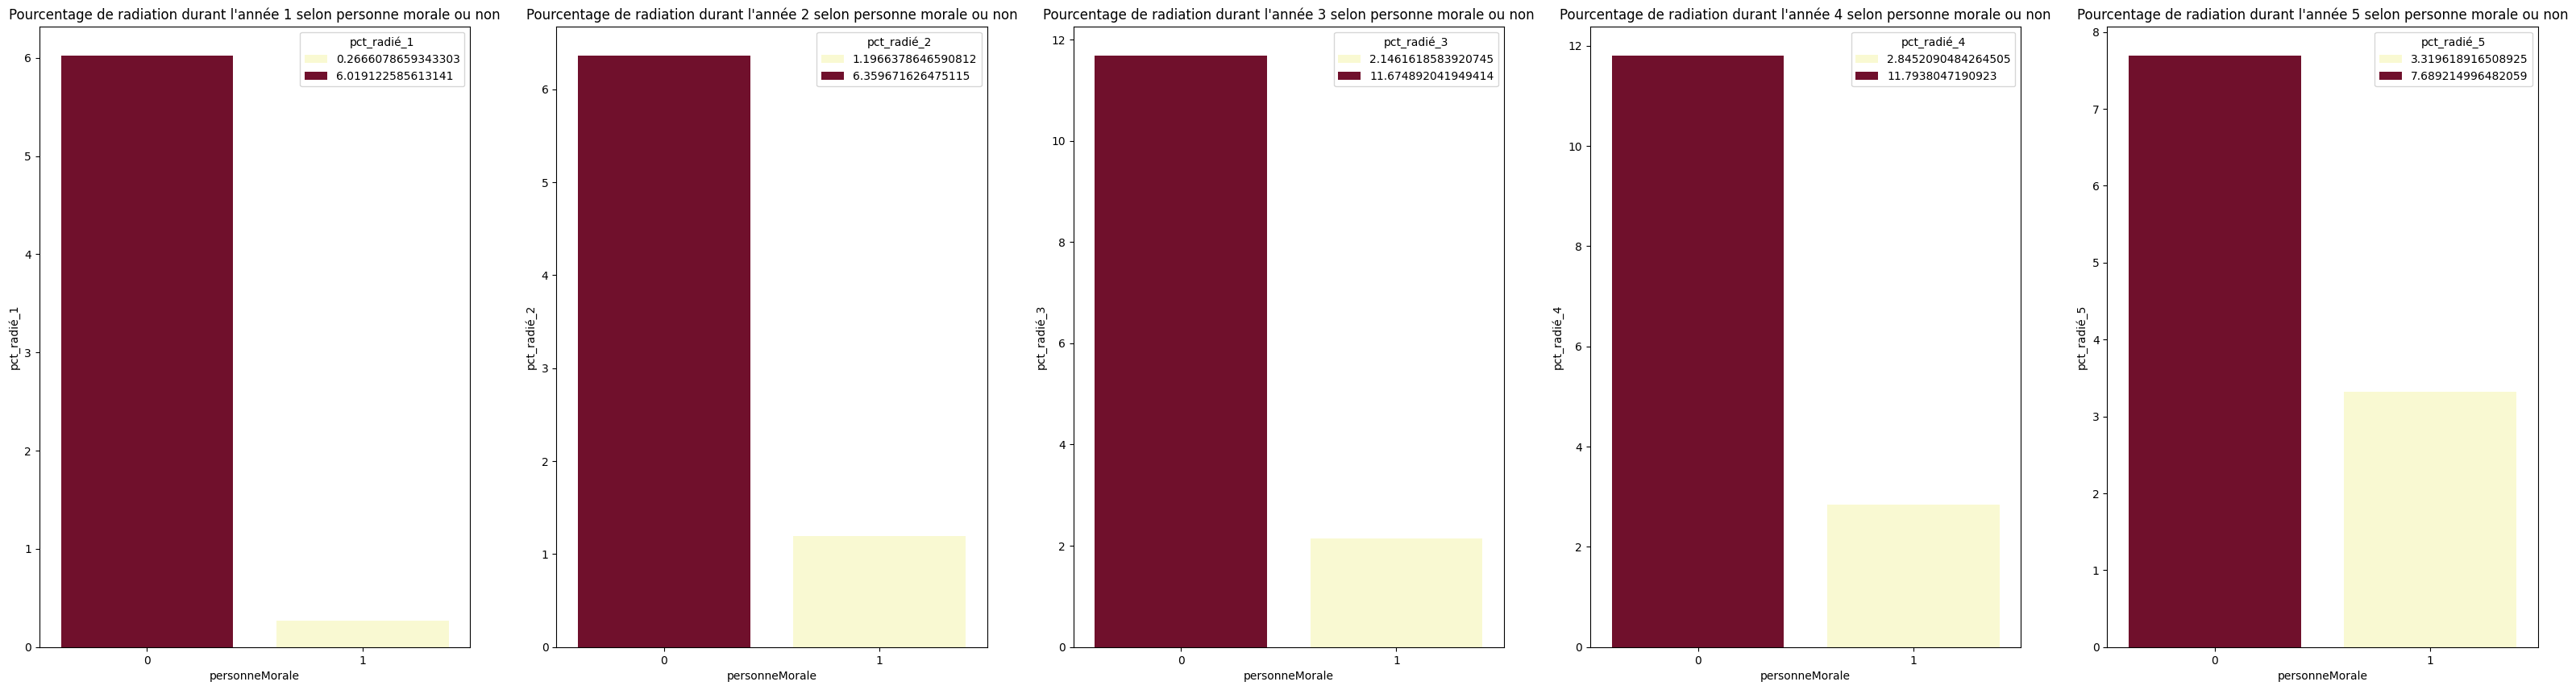

In [309]:
title = [f"Pourcentage de radiation durant l'année {i+1} selon personne morale ou non" for i in range(5)]
figsize = (40,10)
barplot_cat("personneMorale",dfs,figsize,title)

On remarque que le fait d'être une personne physique (personneMorale == 0) est corrélé à de bien plus forte chance de radiation au cours des années suivants la création. Ceci peut s'expliquer par le fait que les personnes physiques sont plus à même d'ouvrir des activités de faible envergures, avec peu de moyens. D'autre part, on pourrait penser que le nombre d'activités ouvertes qui ne sont pas "réelles" est beaucoup plus élevé chez les personnes physiques. Par exemple, il n'est pas rare qu'un individu ouvre une microentreprise qui n'est jamais réellement en activité (type compte uber eats par exemple).

On peut regarder le même graphique mais cette fois pour les microentreprises. Le constat est le même.

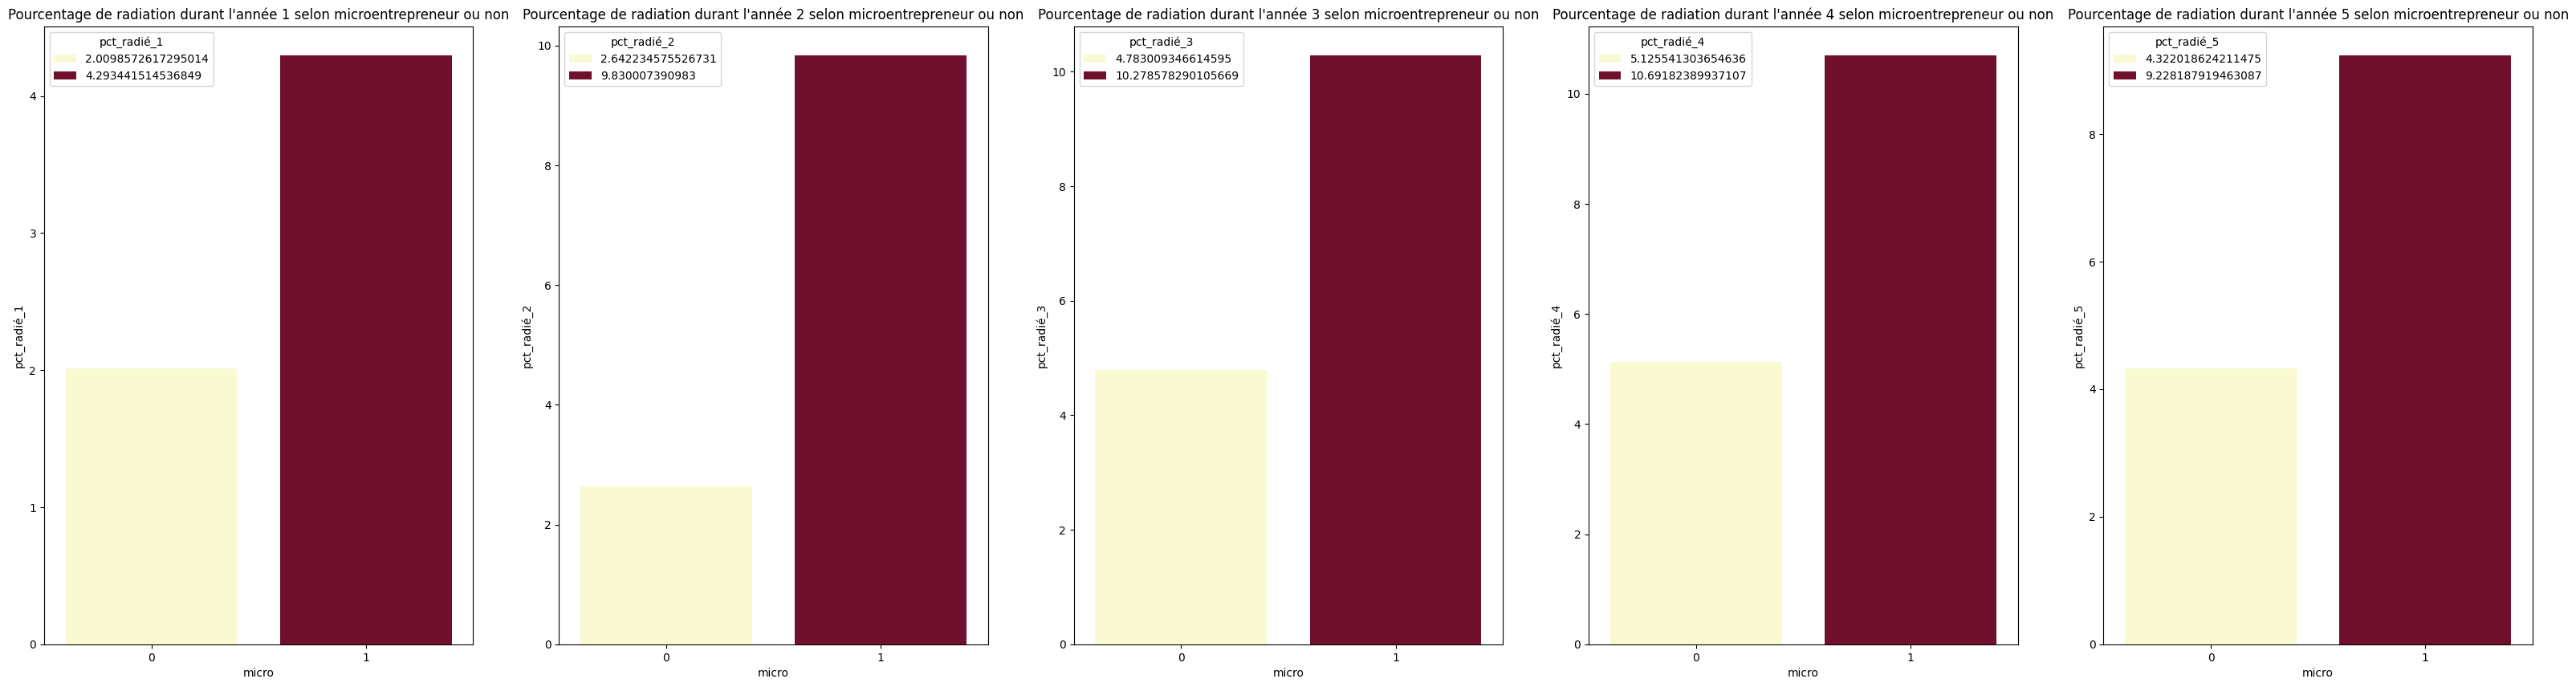

In [310]:
title = [f"Pourcentage de radiation durant l'année {i+1} selon microentrepreneur ou non" for i in range(5)]
figsize = (40,10)
barplot_cat("micro",dfs,figsize,title)

### Le département à t-il un impact sur le nombre d'entreprises radiées en son sein ?

Visualisons d'abord le pourcentage d'entreprise radiée par département évalué pour chaque $df_i$ : 

In [267]:
#Récupération des départements 
data["cp"] = data["code_postal"].apply(lambda x : x[0:2])
dfs = get_df_i(data)

Récupération du nombre d'entreprise radiée au cours de la i eme année après la création et du nombre total d'entreprise crées, le tout par département :  


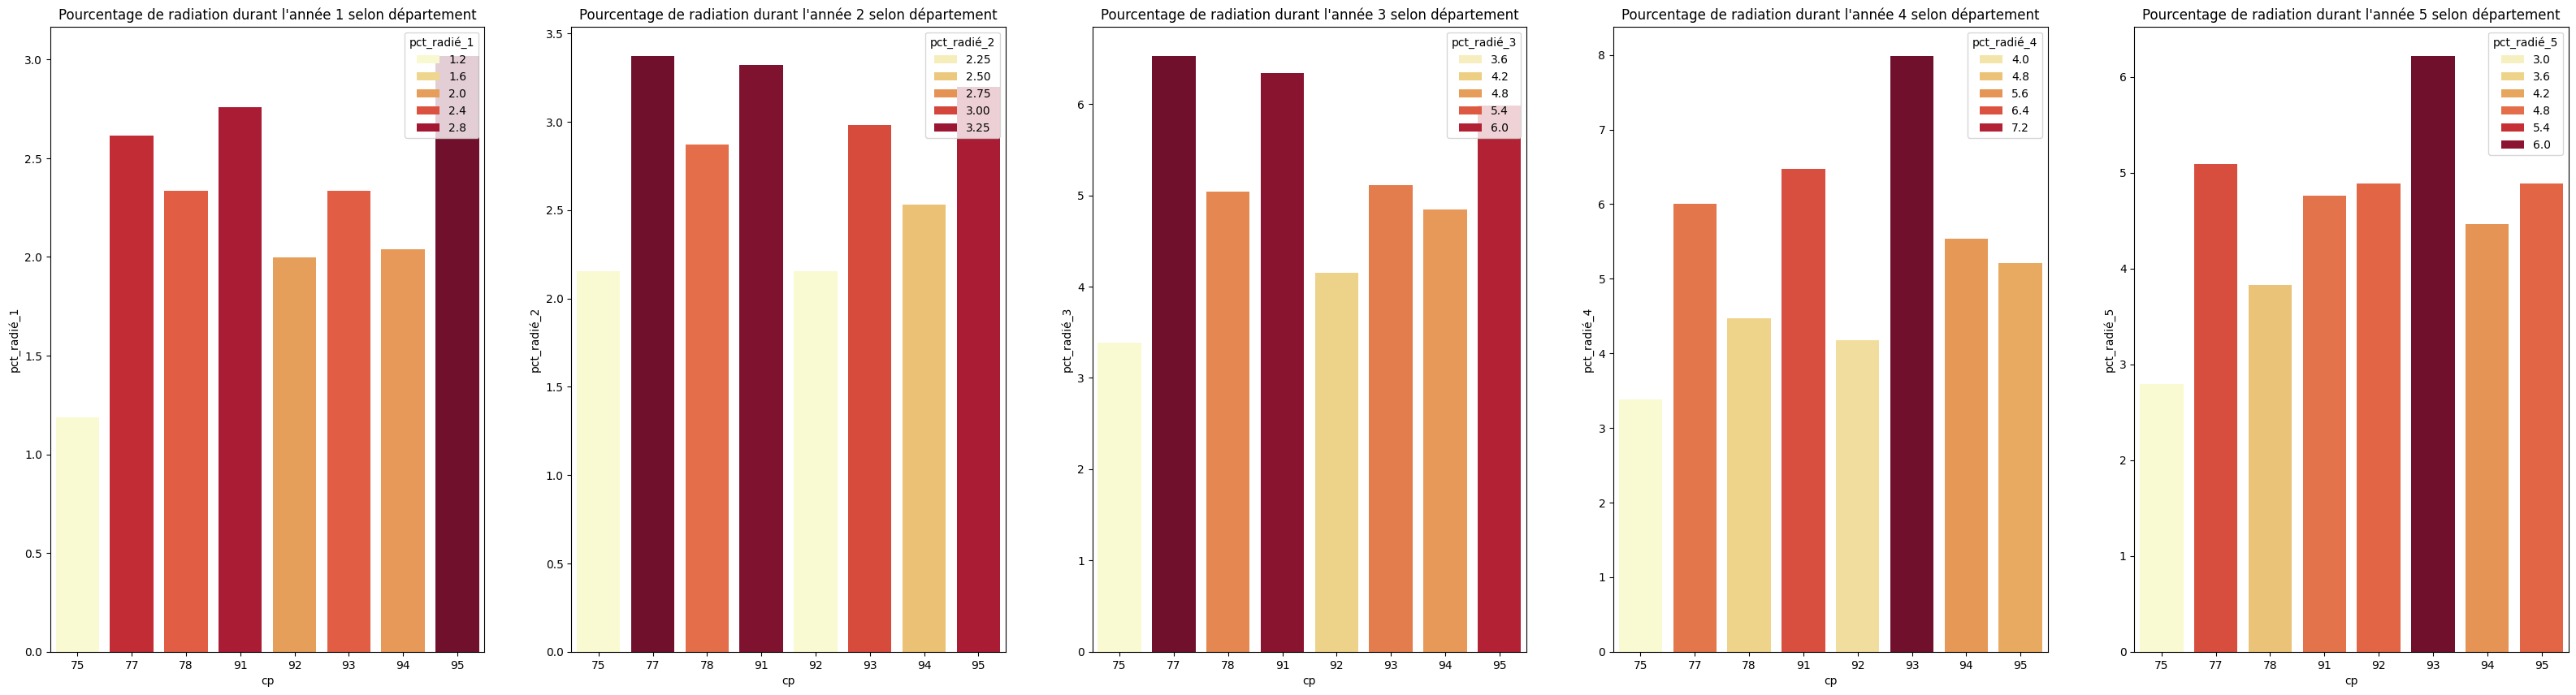

In [270]:
title = [f"Pourcentage de radiation durant l'année {i+1} selon département" for i in range(5)]
figsize = (40,10)
barplot_cat("cp",dfs,figsize,title)

On remarque qu'au cours de la première année après la création d'entreprise, c'est le 95 qui arrive en tête du classement du nombre de radiation relativement au nombre d'entreprise ouvertes dans le département depuis 2010 et jusqu'en 2024, avec plus de 3% de radiations du RNE.

Au cours de la deuxième année après la création d'entreprise, la tendance reste à peu près la même à la différence que désormais, le 77 et le 93 rejoignent le 95, avec plus de 4% de radiations du RNE.

Pour la troisième année suivant la création d'entreprise, c'est le 77 qui arrive en tête, avec plus de 7% de radiations.

Les 4ème et 5ème années suivant la création d'entreprise sont équivalentes.

Il y a donc visiblement une réelle hétérogénéité selon les départements. Il faudra donc évalué la pertinence de la variable "cp" dans une future modélisation.

On notera qu'il est plus rare de se faire radié du RNE lors la première année suivant la création, dans tous les cas, et que le nombre d'entreprises radiées semble augmenter avec $i$, l'année suivant la création d'entreprise.

### La taille de la commune d'implentation peut-elle jouer dans sur le nombre d'entreprise radié ? La concurrence locale peut-elle jouer ?

L'effet n'est pas forcément très claire : d'un côté on pourrait penser que s'implanter dans une grande ville pourrait augmenter la probabilité de "réussir" en trouvant une demande conséquente. Mais de l'autre côté, le nombre de concurrent pourrait être accru, et il serait dans ce cas probablement délétère de s'installer dans une grande ville en tant que commerçant, restaurateur ou hôtelier. Ici "réussir" est à prendre avec des pincettes car nos variables $radié_i$ portent en eux une partie de l'information de la réussite d'une entreprise, mais pas que, comme nous l'avons vu plus haut dans la construction de ces dernières.

Pour cela, on considère trois types de villes : 

- les villages, comprenant de 0 à 5000 habitants (valeur "village")
- les villes dites "petites", comprenant de 5000 à 25 000 habitants (valeur "little")
- les villes dites "moyennes", comprenant de 25 000 à 50 000 habitants (valeur "middle")
- les villes dites "grandes", comprenant plus de 50 000 habitants (valeur "big")

On utilise pour cela la variable `pop_commune` et on créer une nouvelle variable nommé `taille_ville` :

In [271]:
#Création de taille_ville
data["taille_ville"] = data["pop_commune"].apply(
    lambda x: "village" if x < 5000
    else "little" if x < 25000
    else "middle" if x < 50000
    else "big"
)

In [272]:
dfs = get_df_i(data)

Le graphique suivant est assez tautologique mais montre bien que plus il y a un grand nombre d'habitant, plus il y a d'entreprise crées...

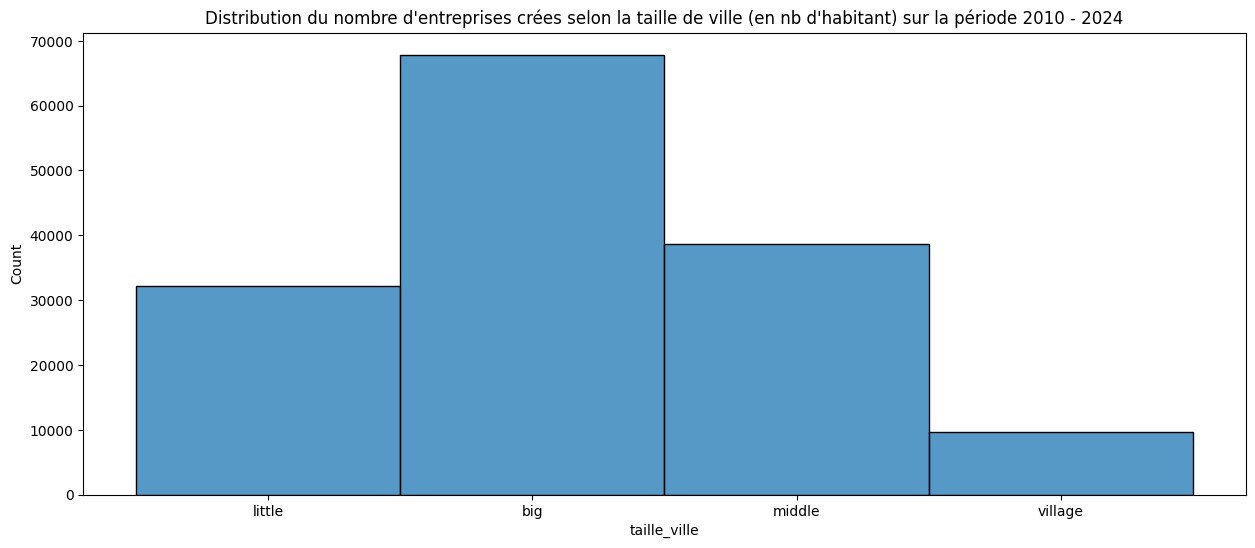

In [273]:
#distribution du nombre d'entreprises crées selon la taille de ville (en nb d'habitant) sur la période 2010 - 2024
plt.figure(figsize=(15,6))
sns.histplot(x="taille_ville",data = data)
plt.title("Distribution du nombre d'entreprises crées selon la taille de ville (en nb d'habitant) sur la période 2010 - 2024")
plt.show()

Voici les barplots d'intérêt pour la taille de ville : 

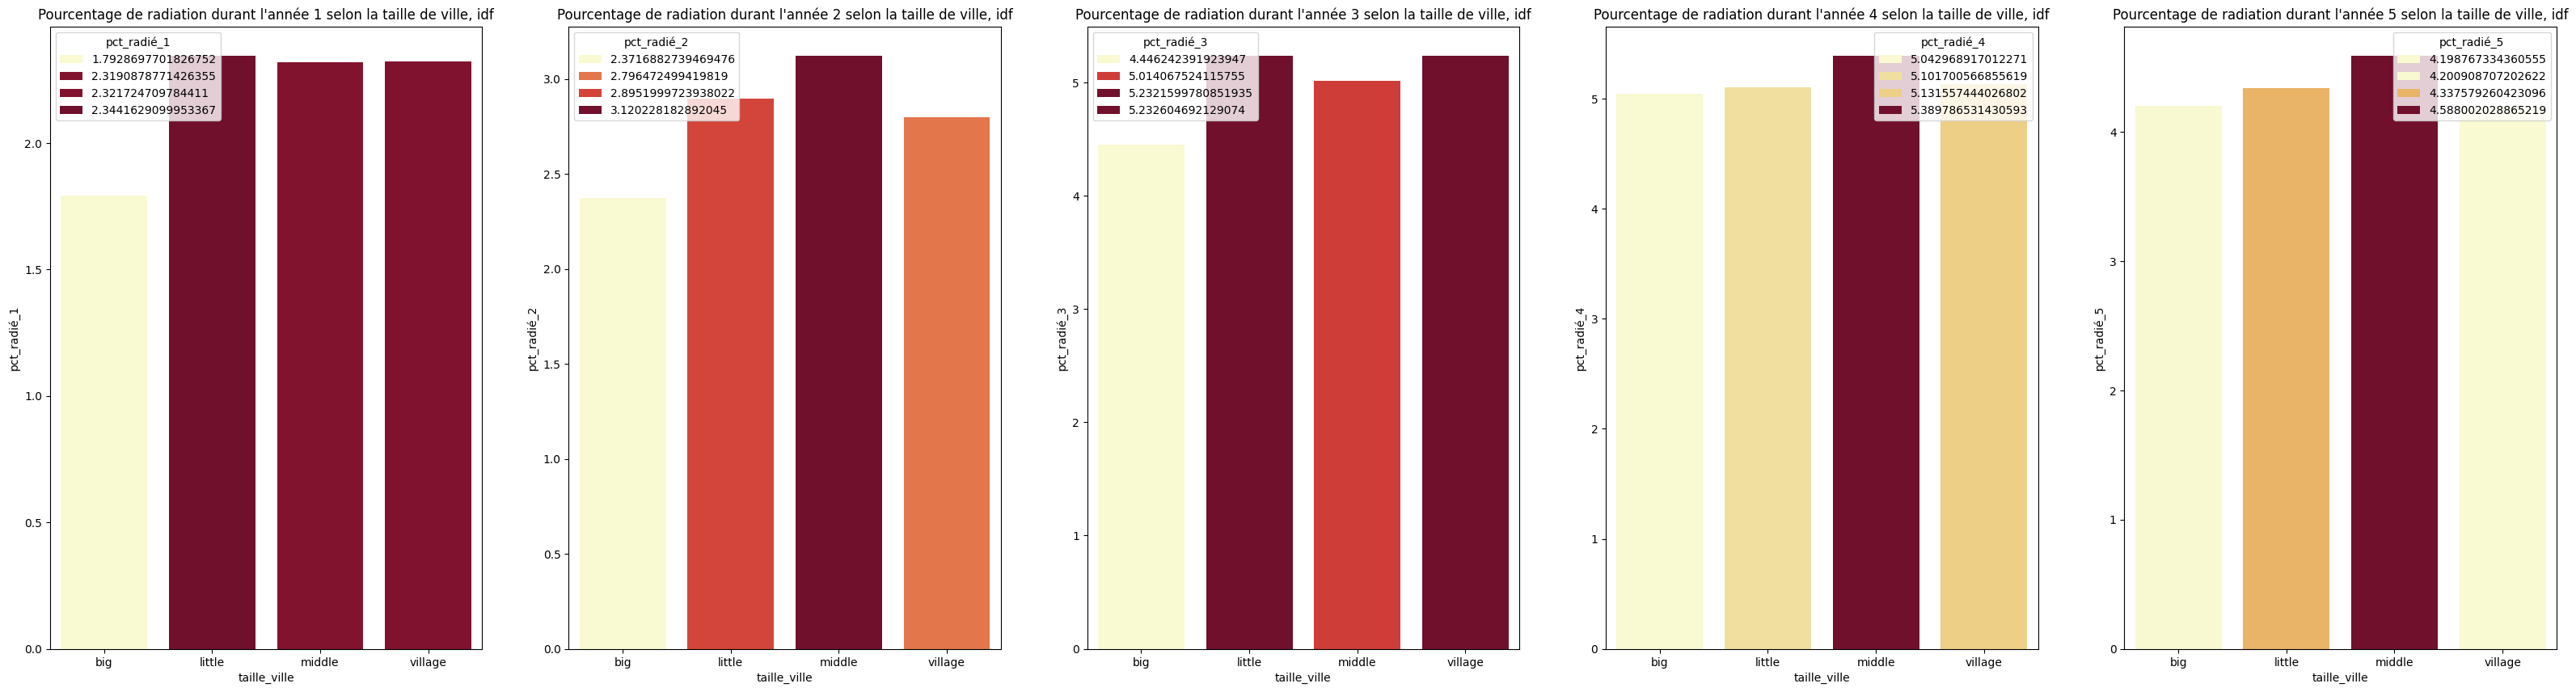

In [275]:
title = [f"Pourcentage de radiation durant l'année {i+1} selon la taille de ville, idf" for i in range(5)]
figsize = (40,10)
barplot_cat("taille_ville",dfs,figsize,title)

On remarque qu'en grande majorité, le fait d'ouvrir son entreprise dans une grande ville est corrélé avec une diminution des chances d'être radié du RNE. l'hétérogénéité semble assez marqué pour les années 1,2, et 3 suivants la création d'entreprise.

Cependant, elle diminue fortement pour les années 4 et 5 suivant la création d'entreprise.

La variable `taille_ville` semble donc pertinente au moins pour les années 1,2 et 3 suivants la création d'entreprise.
Cela est moins sûr pour les années 4 et 5. On garde cette variable pour évaluer sa pertinence dans une modélisation future.

Pour essayer de mieux saisir les choses, évaluons le ratio nombre de concurrents locaux / nombre d'habitant, et regardons si celui-ci est corrélé à la radiation d'entreprise. En principe, on s'attend à ce que plus le nombre de concurrent est élevé par rapport au nombre d'habitant, plus les marchés sont saturés; en raisonnant 
naïvement ici sur tout type de secteurs confondus, et si l'on considère l'information partielle de "réussite" que pourrait nous donner nos variables cibles.

In [276]:
data["concu/hab"] = data["nb_local_concurrents"]/data["pop_commune"] 

In [277]:
dfs = get_df_i(data)

On effectue un test de corrélation pour évaluer la significativité de la corrélation entre "radié" et "concu/hab".

Pour cela, on peut considérer la régression linaire suivant : 
    $\hat{concu/hab} = \hat{\alpha} + \hat{\beta} * radié_i$.

Sous des hypothèses de moments, d'indépendance et de distribution identique et d'inversibilité (ici toutes vérifiés trivialement puisque $radié_i$ est binaire, et qu'il est a priori certain que les couples $((concu/hab)_n, (radié_{i})_n)$ soient i.i.d), peut effectuer sereinement le test de significativité suivant :

 $H_0$ : $\beta = 0$ VS $H_1$ : $\beta \neq 0$




$\hat{\beta}$ est significatif au seuil de 5% asymptotique pour les années 1 et 5 suivants la création, et non significatif à ce seuil pour les autres. La valeur des coefficients est cependant très faible, ce qui indique une très faible corrélation entre le fait d'avoir été radié au cours de l'année $i$ suivant la création, et la densité de concurrence locale. Dans tous les cas, le signe de la corrélation est négatif, ce qui veut dire que le fait d'être radié l'année $i$ suivant la création est corrélé avec une baisse de la densité de concurrence locale, ce qui n'était pas forcément attendue.

On testera tout de même la pertinence de la variable `concu/hab` dans une future modélisation.

In [278]:
var_cible = ["radié1","radié2","radié3","radié4","radié5"]

for df,var_name in zip(dfs,var_cible):
    X = df.loc[~df["concu/hab"].isna()][var_name]
    X = sm.add_constant(X)
    y = df.loc[~df["concu/hab"].isna()]["concu/hab"]

    #On regresse et on récupère les écarts types robustes
    model = sm.OLS(y, X).fit(cov_type="HC1")

    coef = model.params[var_name]   
    pval = model.pvalues[var_name]

    print(f"Année {var_name[-1]} suivant la création coefficient",coef)
    print(f"Année {var_name[-1]} suivant la création p-value",pval, "\n")

Année 1 suivant la création coefficient -0.00031222874725865096
Année 1 suivant la création p-value 5.296618139652586e-10 

Année 2 suivant la création coefficient -6.270725249072048e-05
Année 2 suivant la création p-value 0.39135733262142947 

Année 3 suivant la création coefficient 6.392796273307677e-05
Année 3 suivant la création p-value 0.14785646219226595 

Année 4 suivant la création coefficient 0.00011420821322876832
Année 4 suivant la création p-value 0.3872465729911987 

Année 5 suivant la création coefficient -0.00013793370480881794
Année 5 suivant la création p-value 2.6220870816060963e-05 



### Le secteur d'activité à-il une influence sur le nombre d'entreprise radiées ?

On rappelle les secteurs d'activités sélectionnés depuis le NAF dans la partie "récupération de données" : 

    ("4511Z","Commerce de voitures et de véhicules automobiles légers"),
    ("4519Z","Commerce d'autres véhicules automobiles"),
    ("4520A","Entretien et réparation de véhicules automobiles légers"),
    ("4520B", "Entretien et réparation d'autres véhicules automobiles"),
    ("4532Z","Commerce de détail d'équipements automobiles"),
    ("4540Z","Commerce et réparation de motocycles"),
    ("4711A", "Commerce de détail de produits surgelés"),
    ("4711B","Commerce d'alimentation générale"),
    ("4711C","Supérettes"),
    ("4711D","Supermarchés"),
    ("4711E","Magasins multi-commerces"),
    ("4719B","Autres commerces de détail en magasin non spécialisé"),
    ("4721Z","Commerce de détail de fruits et légumes en magasin spécialisé"),
    ("4722Z ","Commerce de détail de viandes et de produits à base de viande en magasin spécialisé"),
    ("4723Z","Commerce de détail de poissons, crustacés et mollusques en magasin spécialisé"),
    ("4724Z","Commerce de détail de pain, pâtisserie et confiserie en magasin spécialisé"),
    ("4725Z","Commerce de détail de boissons en magasin spécialisé"),
    ("4726Z","Commerce de détail de produits à base de tabac en magasin spécialisé"),
    ("4729Z","Autres commerces de détail alimentaires en magasin spécialisé"),
    ("4730Z","Commerce de détail de carburants en magasin spécialisé"),
    ("4741Z","Commerce de détail d'ordinateurs, d'unités périphériques et de logiciels en magasin spécialisé"),
    ("4742Z","Commerce de détail de matériels de télécommunication en magasin spécialisé"),
    ("4743Z","Commerce de détail de matériels audio et vidéo en magasin spécialisé"),
    ("4751Z","Commerce de détail de textiles en magasin spécialisé"),
    ("4752A","Commerce de détail de quincaillerie, peintures et verres en petites surfaces (moins de 400 m²)"),
    ("4759A","Commerce de détail de meubles"),
    ("4759B","Commerce de détail d'autres équipements du foyer"),
    ("4761Z","Commerce de détail de livres en magasin spécialisé"),
    ("4762Z","Commerce de détail de journaux et papeterie en magasin spécialisé"),
    ("4763Z","Commerce de détail d'enregistrements musicaux et vidéo en magasin spécialisé"),
    ("4764Z","Commerce de détail d'articles de sport en magasin spécialisé"),
    ("4765Z","Commerce de détail de jeux et jouets en magasin spécialisé"),
    ("4772A","Commerce de détail de la chaussure"),
    ("4772B","Commerce de détail de maroquinerie et d'articles de voyage"),
    ("4771Z","Commerce de détail d'habillement en magasin spécialisé"),
    ("4776Z","Commerce de détail de fleurs, plantes, graines, engrais, animaux de compagnie et aliments pour ces animaux en magasin spécialisé"),
    ("4777Z","Commerce de détail d'articles d'horlogerie et de bijouterie en magasin spécialisé"),
    ("4778C","Autres commerces de détail spécialisés divers"),
    ("4779Z","Commerce de détail de biens d'occasion en magasin"),
    ("4781Z","Commerce de détail alimentaire sur éventaires et marchés"),
    ("4782Z","Commerce de détail de textiles, d'habillement et de chaussures sur éventaires et marchés"),
    ("4789Z","Autres commerces de détail sur éventaires et marchés"),
    ("4799A","Vente à domicile"),
    ("5510Z","Hôtels et hébergement similaire"),
    ("5520Z","Hébergement touristique et autre hébergement de courte durée"),
    ("5610A","Restauration traditionnelle"),
    ("5610C","Restauration de type rapide"),
    ("5621Z","Services des traiteurs"),
    ("5630Z","Débits de boissons")


In [279]:
activites_annotees = [
    ("4511Z","Commerce de voitures et de véhicules automobiles légers"),
    ("4519Z","Commerce d'autres véhicules automobiles"),
    ("4520A","Entretien et réparation de véhicules automobiles légers"),
    ("4520B", "Entretien et réparation d'autres véhicules automobiles"),
    ("4532Z","Commerce de détail d'équipements automobiles"),
    ("4540Z","Commerce et réparation de motocycles"),
    ("4711A", "Commerce de détail de produits surgelés"),
    ("4711B","Commerce d'alimentation générale"),
    ("4711C","Supérettes"),
    ("4711D","Supermarchés"),
    ("4711E","Magasins multi-commerces"),
    ("4719B","Autres commerces de détail en magasin non spécialisé"),
    ("4721Z","Commerce de détail de fruits et légumes en magasin spécialisé"),
    ("4722Z ","Commerce de détail de viandes et de produits à base de viande en magasin spécialisé"),
    ("4723Z","Commerce de détail de poissons, crustacés et mollusques en magasin spécialisé"),
    ("4724Z","Commerce de détail de pain, pâtisserie et confiserie en magasin spécialisé"),
    ("4725Z","Commerce de détail de boissons en magasin spécialisé"),
    ("4726Z","Commerce de détail de produits à base de tabac en magasin spécialisé"),
    ("4729Z","Autres commerces de détail alimentaires en magasin spécialisé"),
    ("4730Z","Commerce de détail de carburants en magasin spécialisé"),
    ("4741Z","Commerce de détail d'ordinateurs, d'unités périphériques et de logiciels en magasin spécialisé"),
    ("4742Z","Commerce de détail de matériels de télécommunication en magasin spécialisé"),
    ("4743Z","Commerce de détail de matériels audio et vidéo en magasin spécialisé"),
    ("4751Z","Commerce de détail de textiles en magasin spécialisé"),
    ("4752A","Commerce de détail de quincaillerie, peintures et verres en petites surfaces (moins de 400 m²)"),
    ("4759A","Commerce de détail de meubles"),
    ("4759B","Commerce de détail d'autres équipements du foyer"),
    ("4761Z","Commerce de détail de livres en magasin spécialisé"),
    ("4762Z","Commerce de détail de journaux et papeterie en magasin spécialisé"),
    ("4763Z","Commerce de détail d'enregistrements musicaux et vidéo en magasin spécialisé"),
    ("4764Z","Commerce de détail d'articles de sport en magasin spécialisé"),
    ("4765Z","Commerce de détail de jeux et jouets en magasin spécialisé"),
    ("4772A","Commerce de détail de la chaussure"),
    ("4772B","Commerce de détail de maroquinerie et d'articles de voyage"),
    ("4771Z","Commerce de détail d'habillement en magasin spécialisé"),
    ("4776Z","Commerce de détail de fleurs, plantes, graines, engrais, animaux de compagnie et aliments pour ces animaux en magasin spécialisé"),
    ("4777Z","Commerce de détail d'articles d'horlogerie et de bijouterie en magasin spécialisé"),
    ("4778C","Autres commerces de détail spécialisés divers"),
    ("4779Z","Commerce de détail de biens d'occasion en magasin"),
    ("4781Z","Commerce de détail alimentaire sur éventaires et marchés"),
    ("4782Z","Commerce de détail de textiles, d'habillement et de chaussures sur éventaires et marchés"),
    ("4789Z","Autres commerces de détail sur éventaires et marchés"),
    ("4799A","Vente à domicile"),
    ("5510Z","Hôtels et hébergement similaire"),
    ("5520Z","Hébergement touristique et autre hébergement de courte durée"),
    ("5610A","Restauration traditionnelle"),
    ("5610C","Restauration de type rapide"),
    ("5621Z","Services des traiteurs"),
    ("5630Z","Débits de boissons")
]

In [280]:
#Récupération de l'annotation pour chaque code APE
ape_dict = dict(activites_annotees)
data["annot_ape"] = data["codeAPE"].map(ape_dict)

In [281]:
dfs = get_df_i(data)

In [283]:
var_cible = ["radié1","radié2","radié3","radié4","radié5"]

#Listes de stockage
nb_rad = list()
nb_crees = list()

for i in range(len(dfs)):

    rad_name = var_cible[i]
    new_var1 = f"nb_radié_{i+1}"
    new_var2 = f"nb_crées_{i+1}"

    #Récupération du nombre d'entreprise radiée au cours de la i eme année après la création par taille de ville 
    rad_it = dfs[i].loc[df1[rad_name] == 1].groupby("annot_ape").size().reset_index(name=new_var1)

    #Récupération du nombre total d'entreprise crées par taille de ville sur la période 2010/2024-(i-1)
    nb_it = dfs[i].groupby("annot_ape").size().reset_index(name=new_var2)

    nb_rad.append(rad_it)
    nb_crees.append(nb_it)

In [284]:
#Récupération sous forme de data frame pour graphique

#Initialisation
df_plot_ape = nb_rad[0].merge(nb_crees[0], on = "annot_ape", how="left")

for i in range(1,len(nb_rad)):
    rad_it = nb_rad[i]
    nb_it = nb_crees[i]
    df_plot_ape_it = rad_it.merge(nb_it, on = "annot_ape", how="left")
    df_plot_ape = df_plot_ape.merge(df_plot_ape_it, on = "annot_ape", how="left")

In [285]:
#Pourcentage d'entreprise radiées au cours de la i ème année après la création par dep, en % par taille de ville
for i in range(len(nb_rad)):
    var_name = f"pct_radié_{i+1}"
    nb_radie = f"nb_radié_{i+1}"
    nb_firme = f"nb_crées_{i+1}"

    df_plot_ape[var_name] = df_plot_ape[nb_radie]/df_plot_ape[nb_firme]*100

Le secteur automobile, ainsi que celui d'éventaires de marchés, sont les plus touchés de manière systématique en termes de radiation du RNE. Globalement, il y a une bonne hétérogénéité dans les radiations par années selon les secteurs d'activités. Il serait donc pertinent d'inclure cette variable dans une modélisation future.

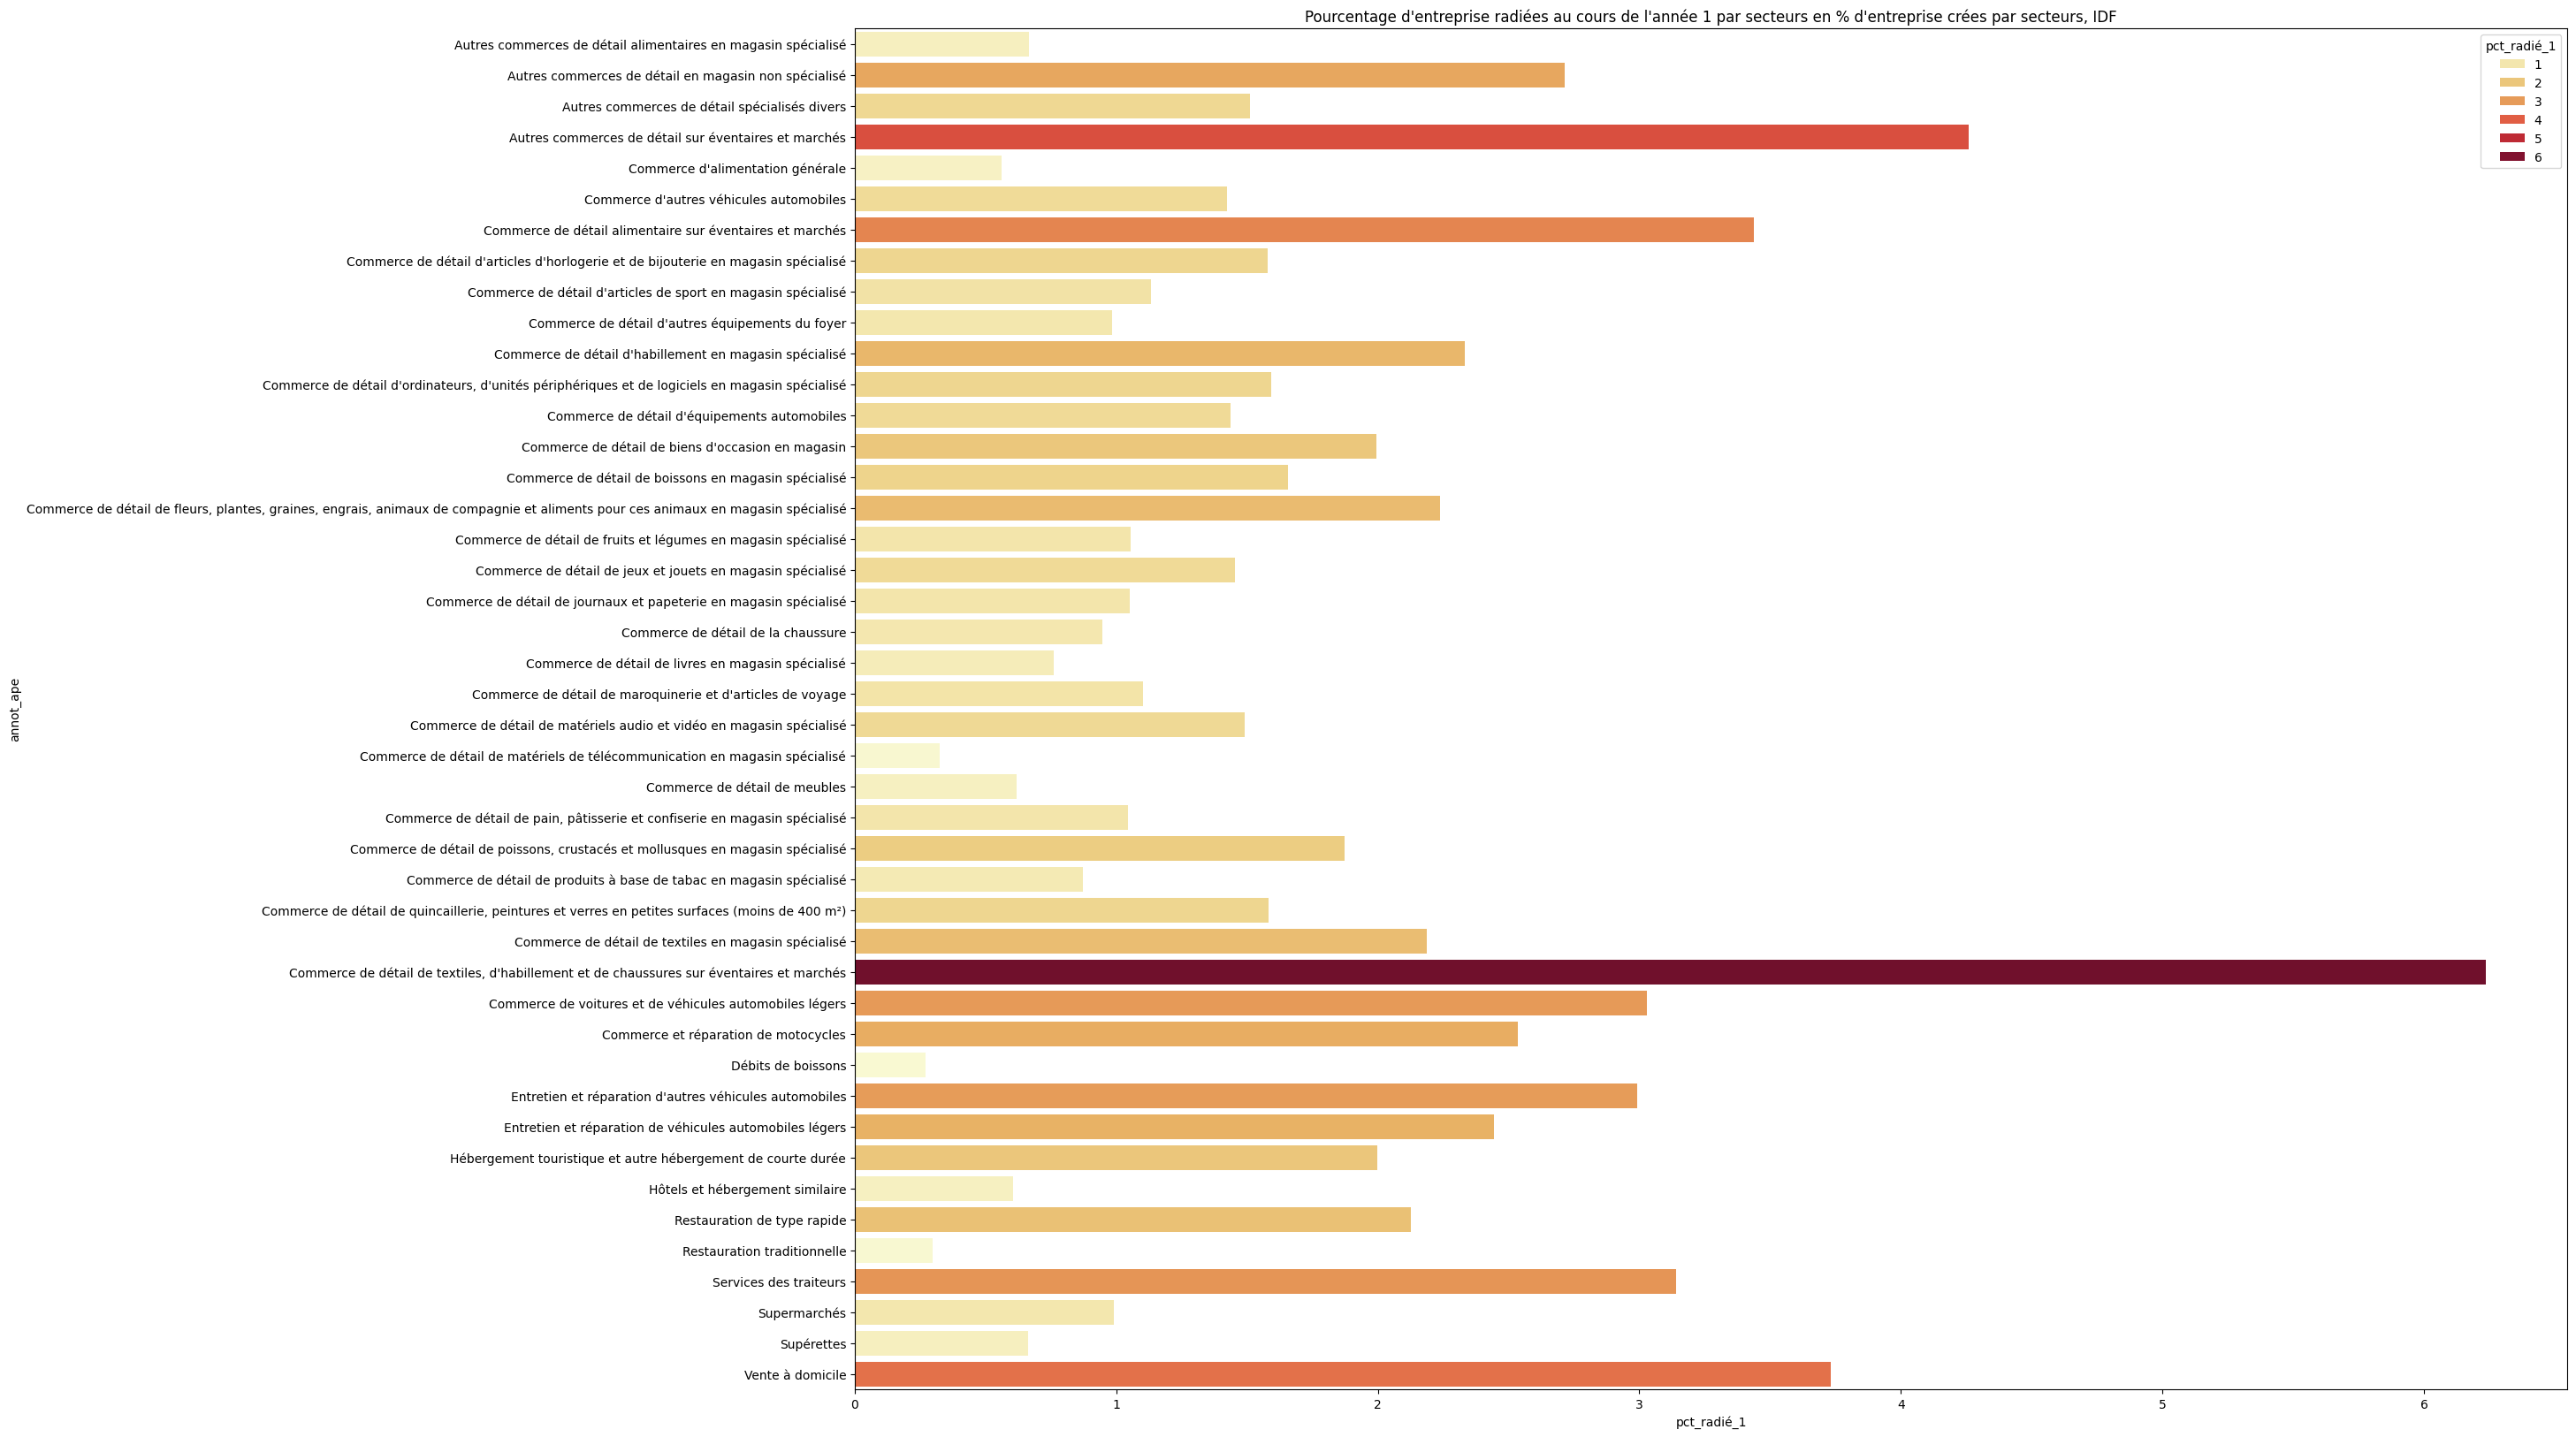

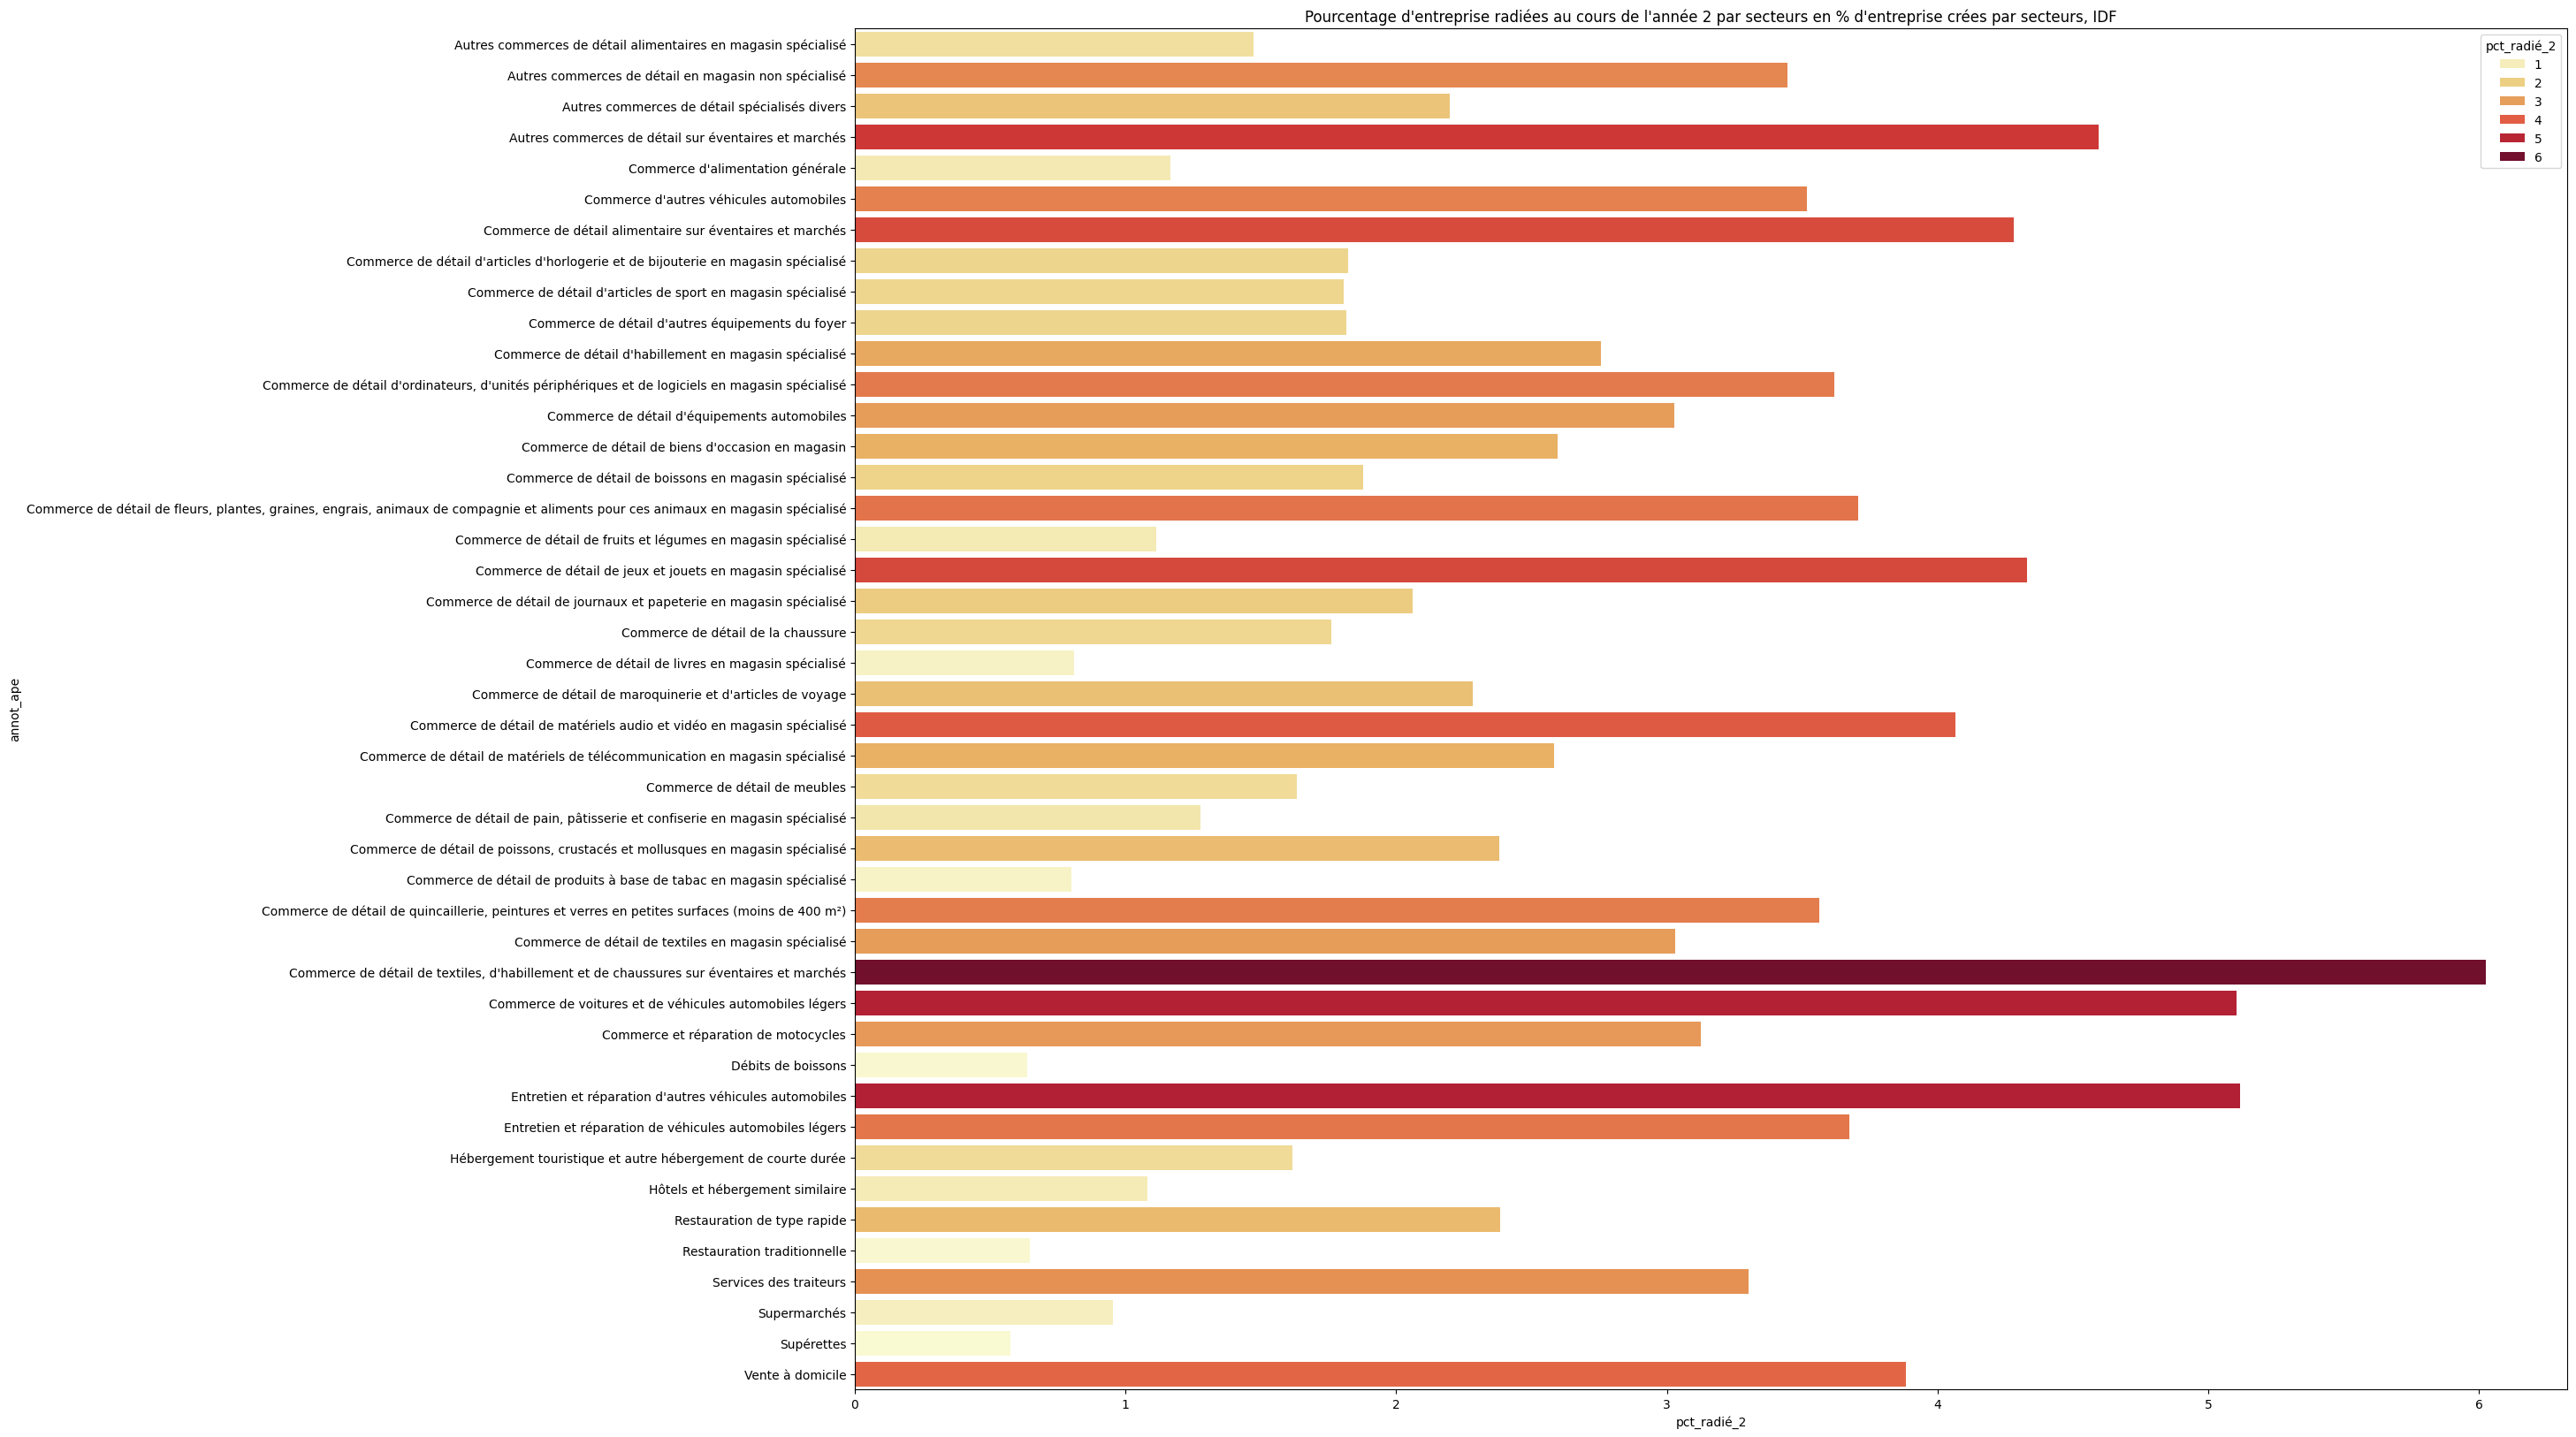

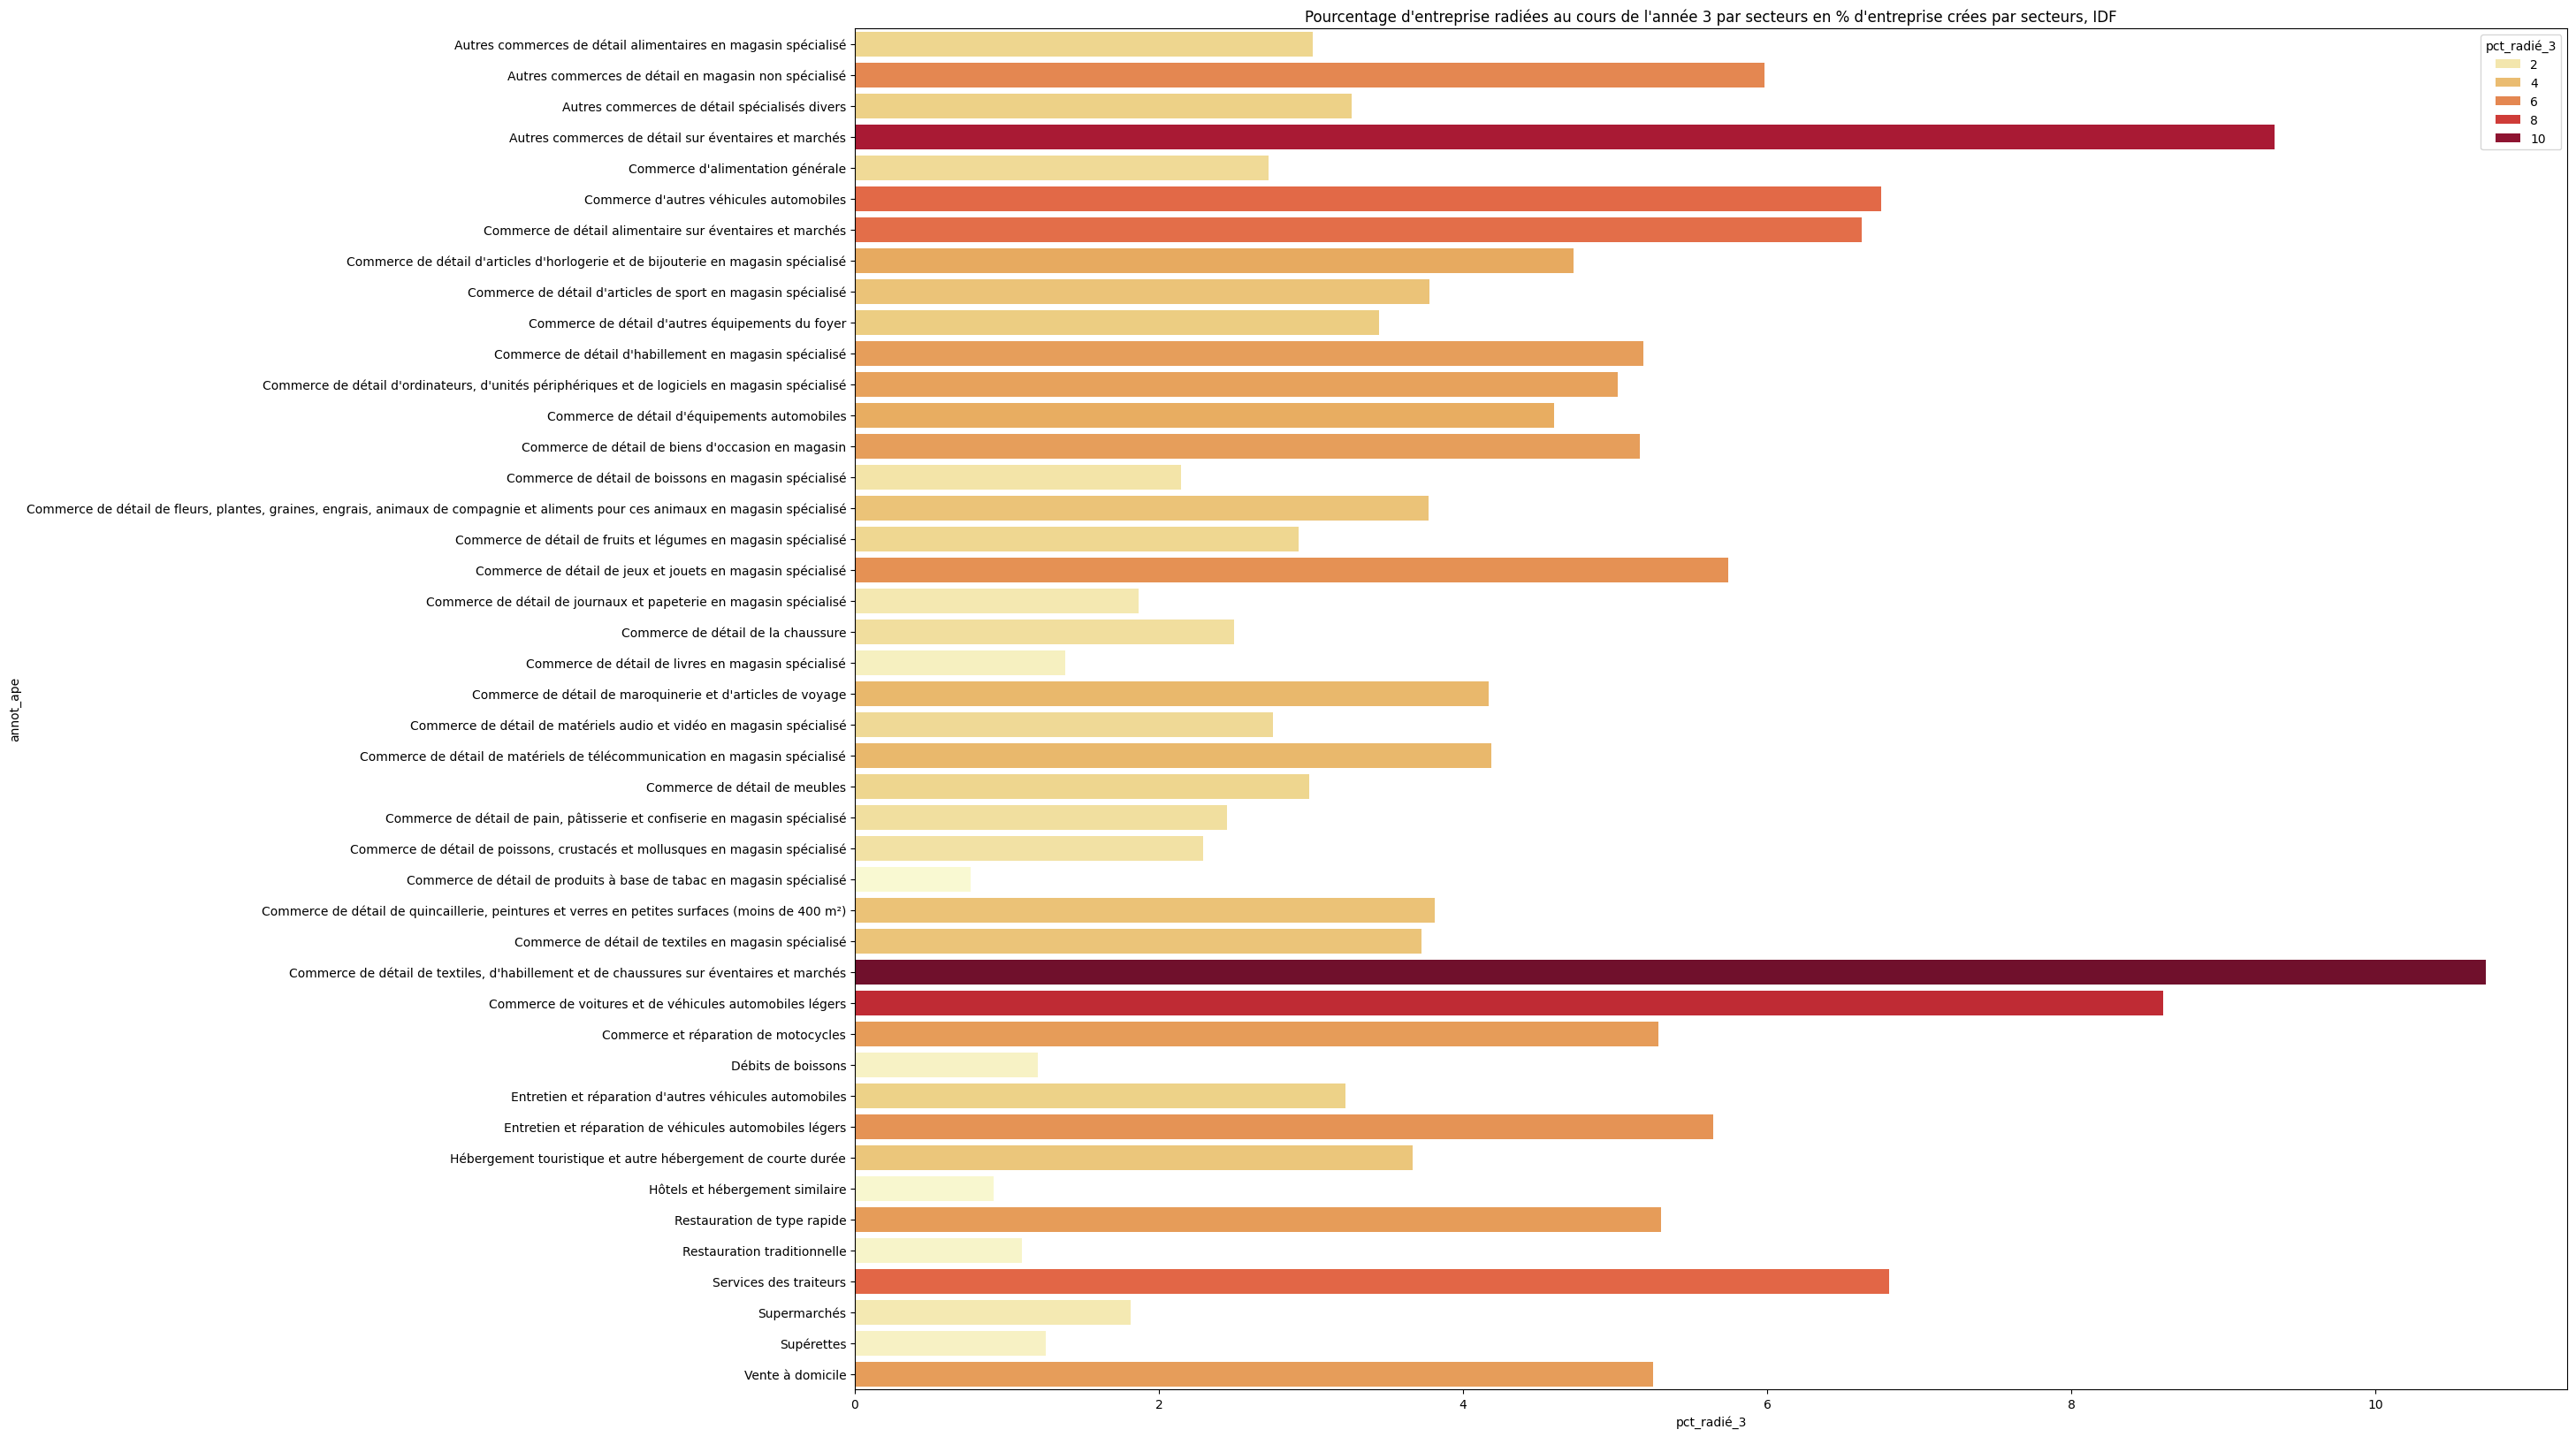

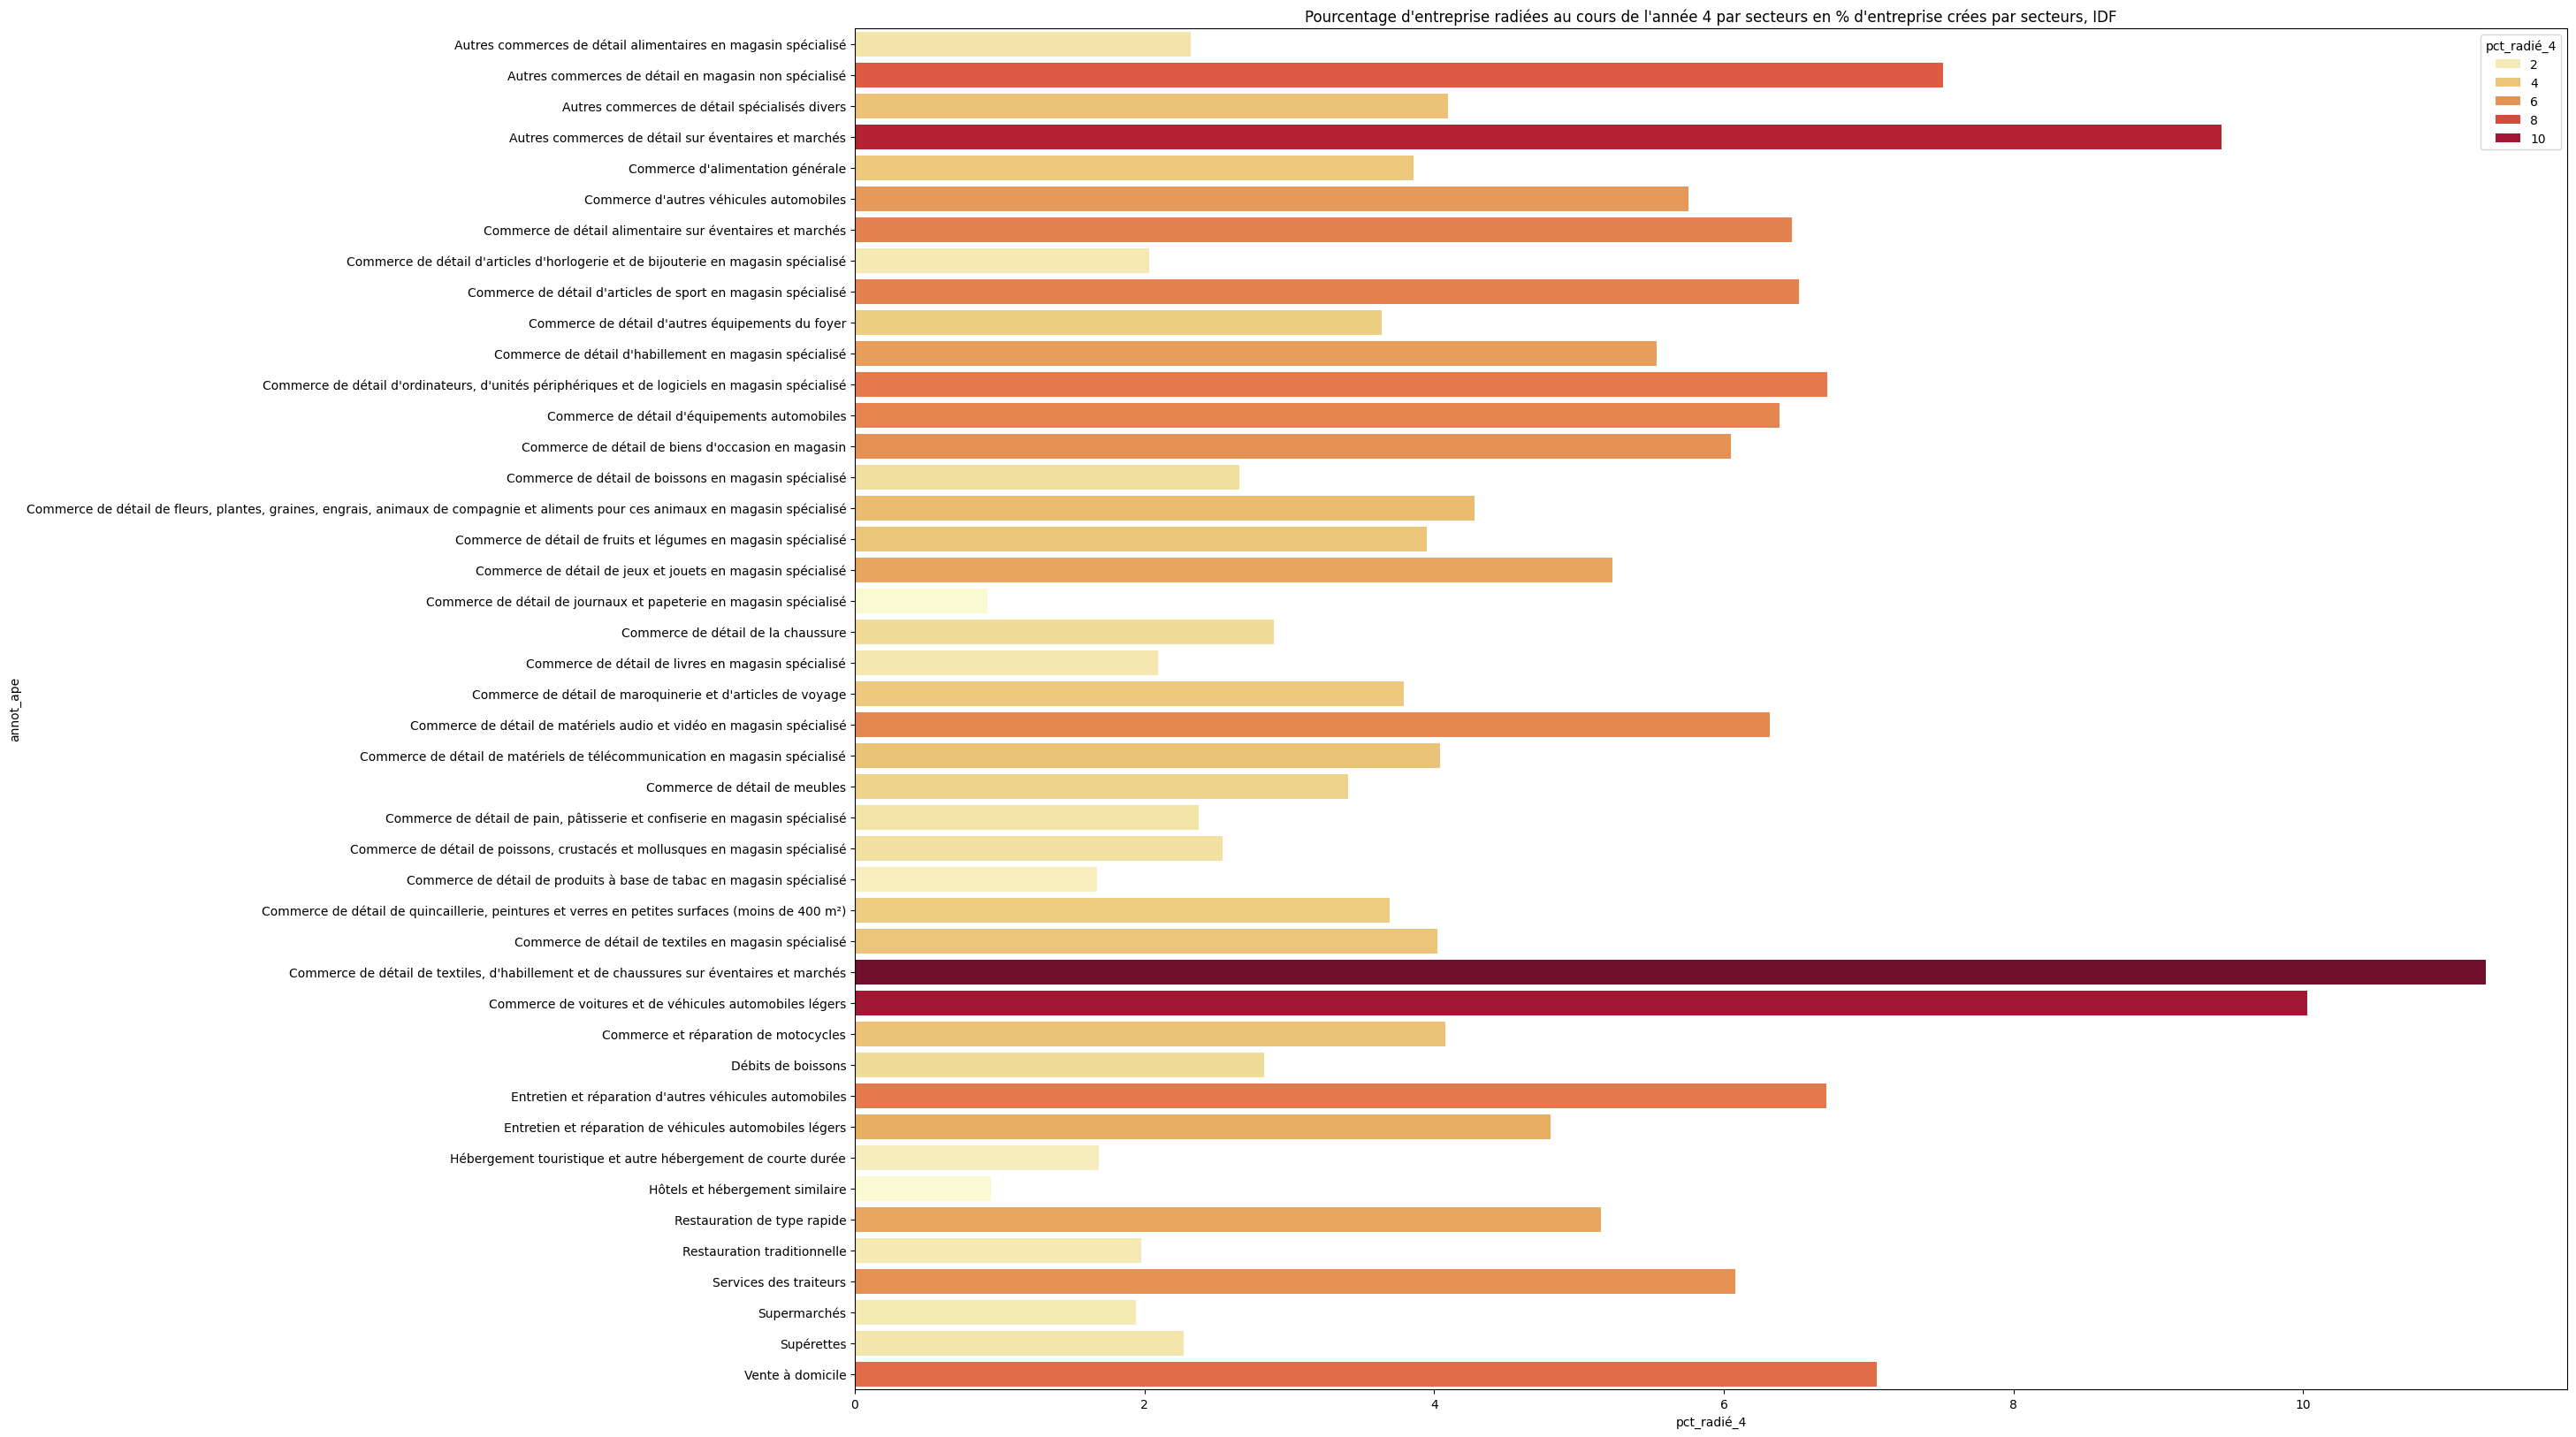

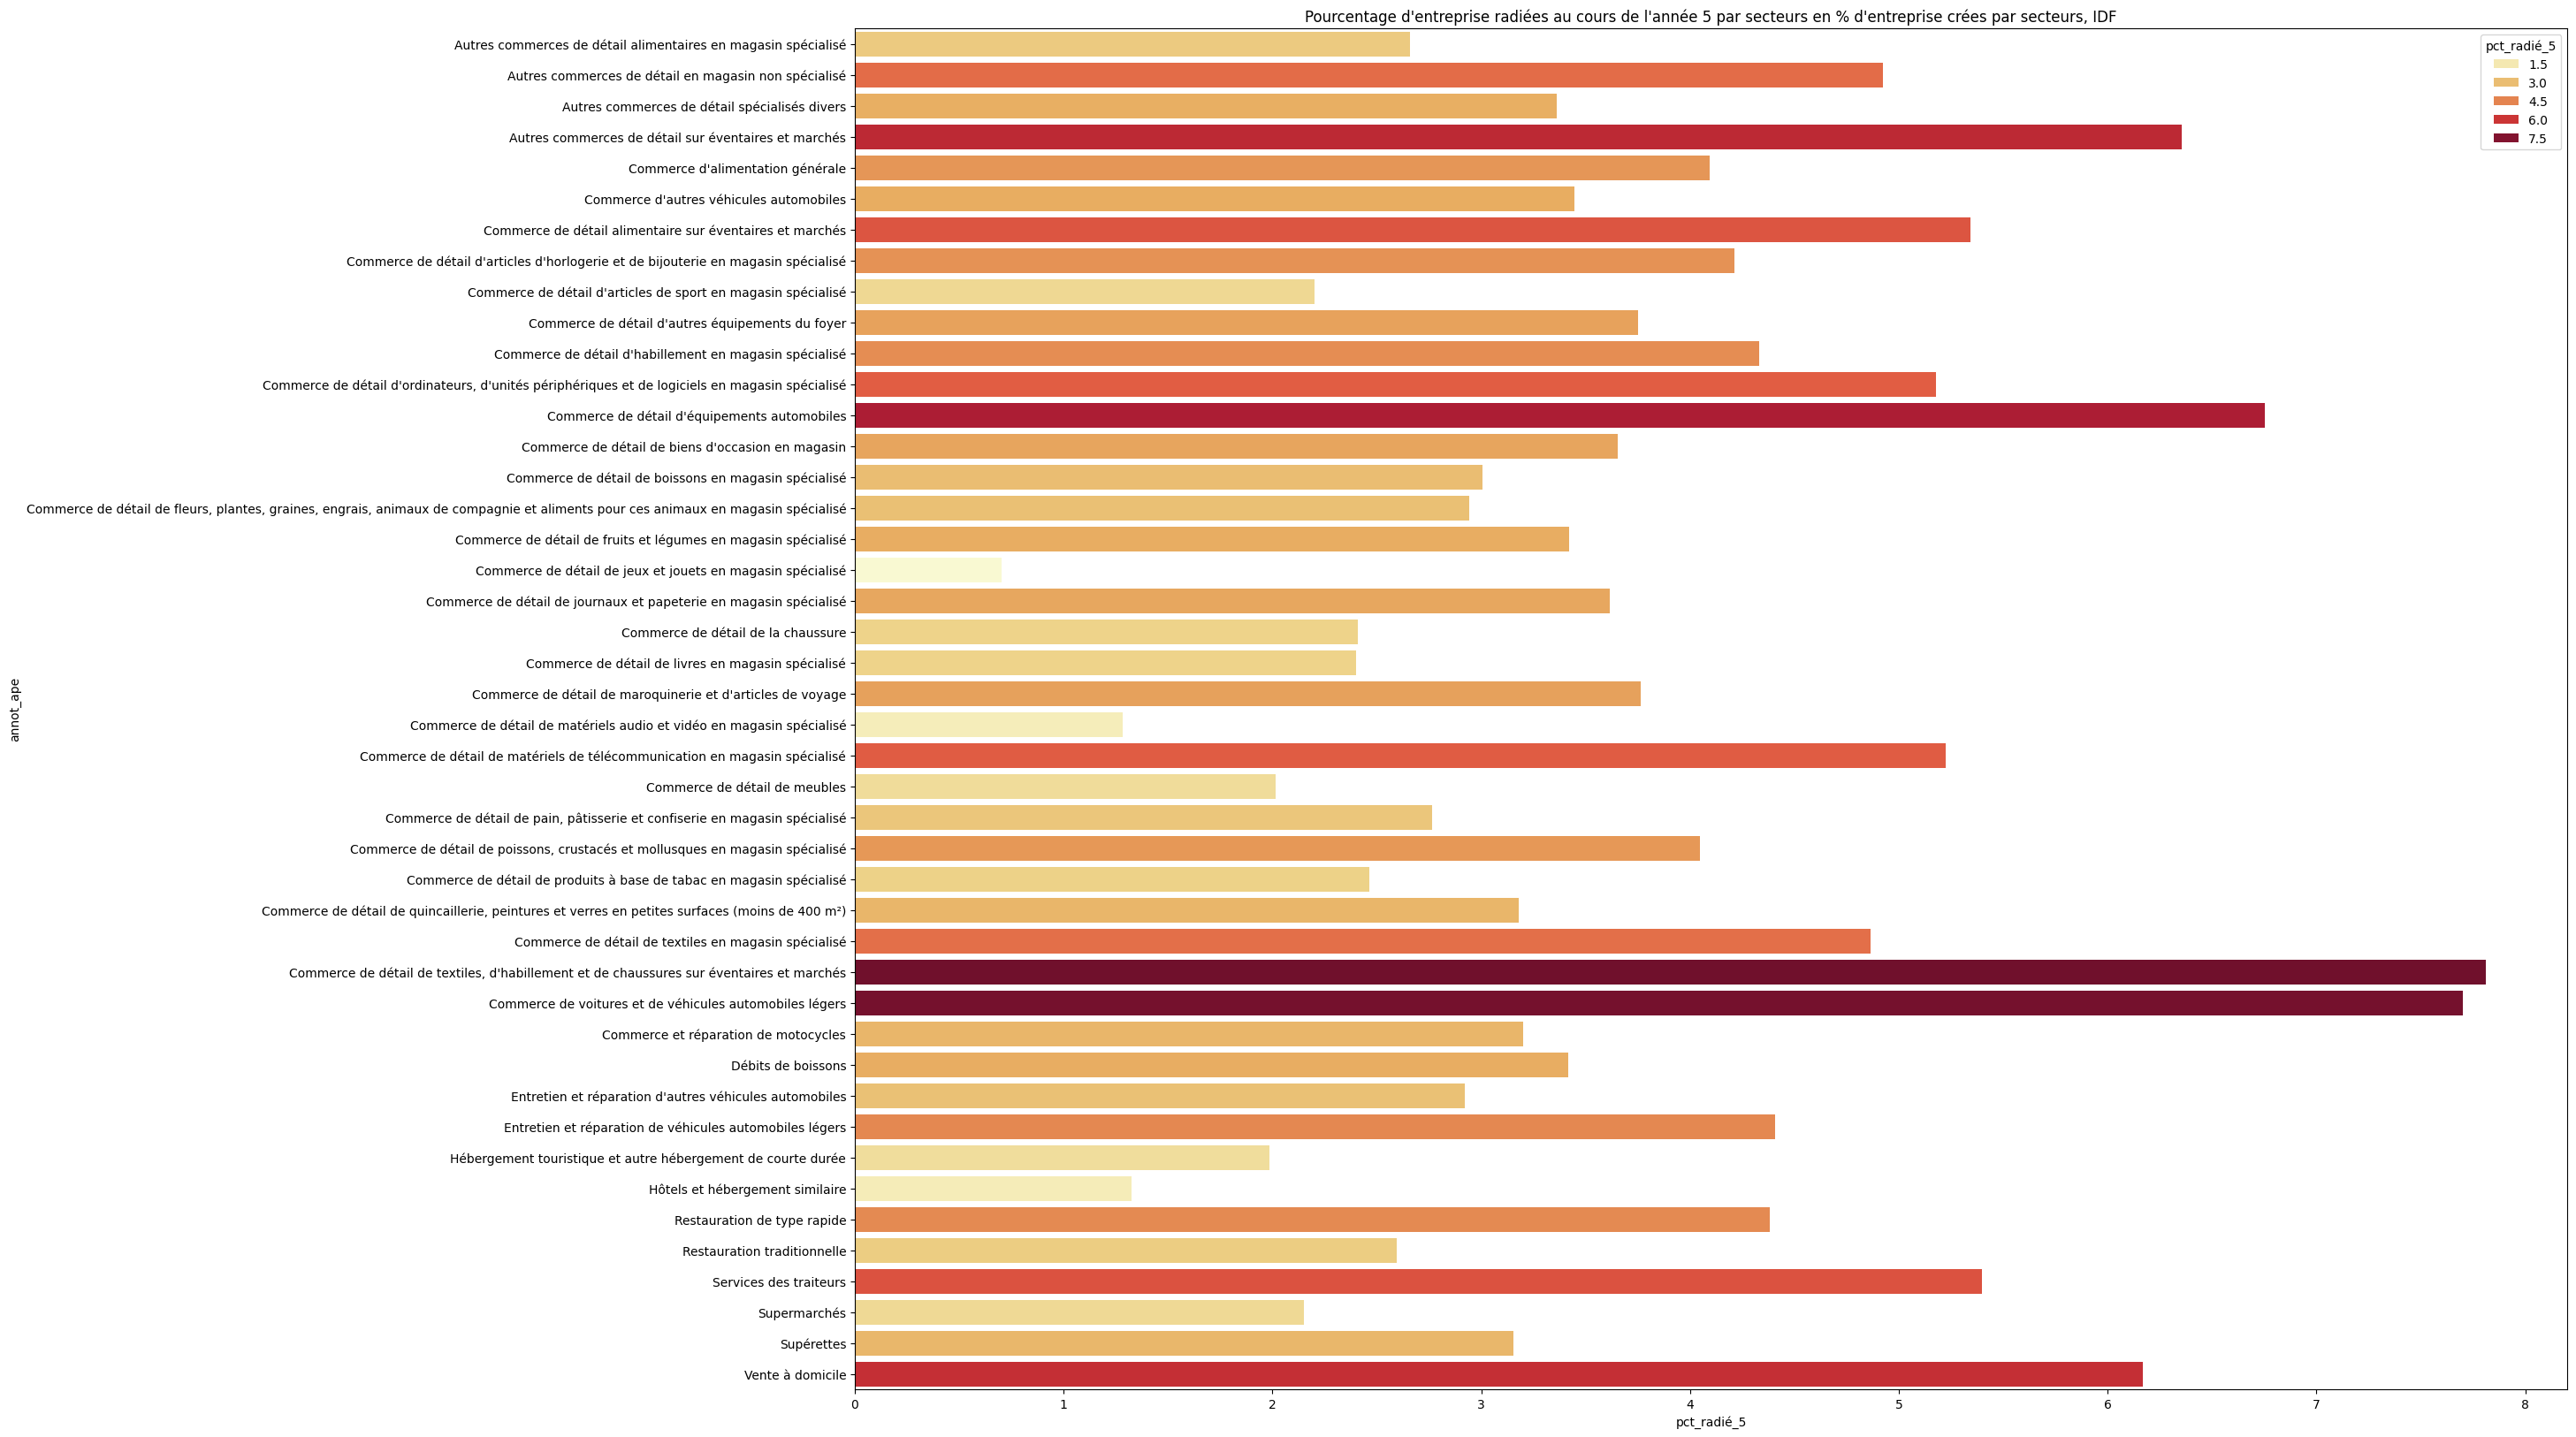

In [286]:
#Barplot pour visualisation des résultats par secteurs d'activités
for i in range(len(dfs)):
    plt.figure(figsize=(25,20))
    var_name = f"pct_radié_{i+1}"
    title = f"Pourcentage d'entreprise radiées au cours de l'année {i+1} par secteurs en % d'entreprise crées par secteurs, IDF"
    sns.barplot(x = var_name, y= "annot_ape", hue = var_name, data=df_plot_ape, palette="YlOrRd")
    plt.title(title)
    plt.show()

### Le revenu médian annuel local peut-il jouer sur les radiations d'entreprises ?

On rappelle que les données obtenues sur les revenus annuels médian de chaque communes n'était disponible que pour l'année 2013 (voire partie récupération des données). De ce fait, les variables `revCommune` et `revDep` (revenus médians annuels par commune / revenus médians annuels par département) constitueront une approximation du revenus par commune et par départements réels, mais sans prendre en compte les dynamiques temporelles. 

On regarde d'abord les valeurs extrêmes et les valeurs manquantes :

In [287]:
data[["revCommune","revDep"]].describe()

,revCommune,revDep
count,148362.000000,148372.000000
mean,23426.518829,23612.861945
std,6580.578440,3554.784813
min,12866.521739,17192.209405
25%,18411.304348,22056.478049
50%,22393.000000,23141.927413
75%,27292.380952,27171.253619
max,43078.888889,27171.253619


On approxime le revenu médian local par le revenu médian départemental pour les 11 manquants

In [288]:
data[["revCommune","revDep"]].isna().sum()

revCommune    10
revDep         0
dtype: int64

In [289]:
data["revCommune"] = data["revCommune"].fillna(data["revDep"])

In [290]:
data[["revCommune","revDep"]].isna().sum()

revCommune    0
revDep        0
dtype: int64

In [291]:
dfs = get_df_i(data)

On commence par visualiser les box plot pour chaque variable `radié_i` : Globalement, pour chaque année de radiation, le constat est le même : il semble que les entreprises radiées au cours de l'année i soient corrélés à un revenu médian local annuel plus faible que les entreprises survivantes à une radiation au cours de l'année i.

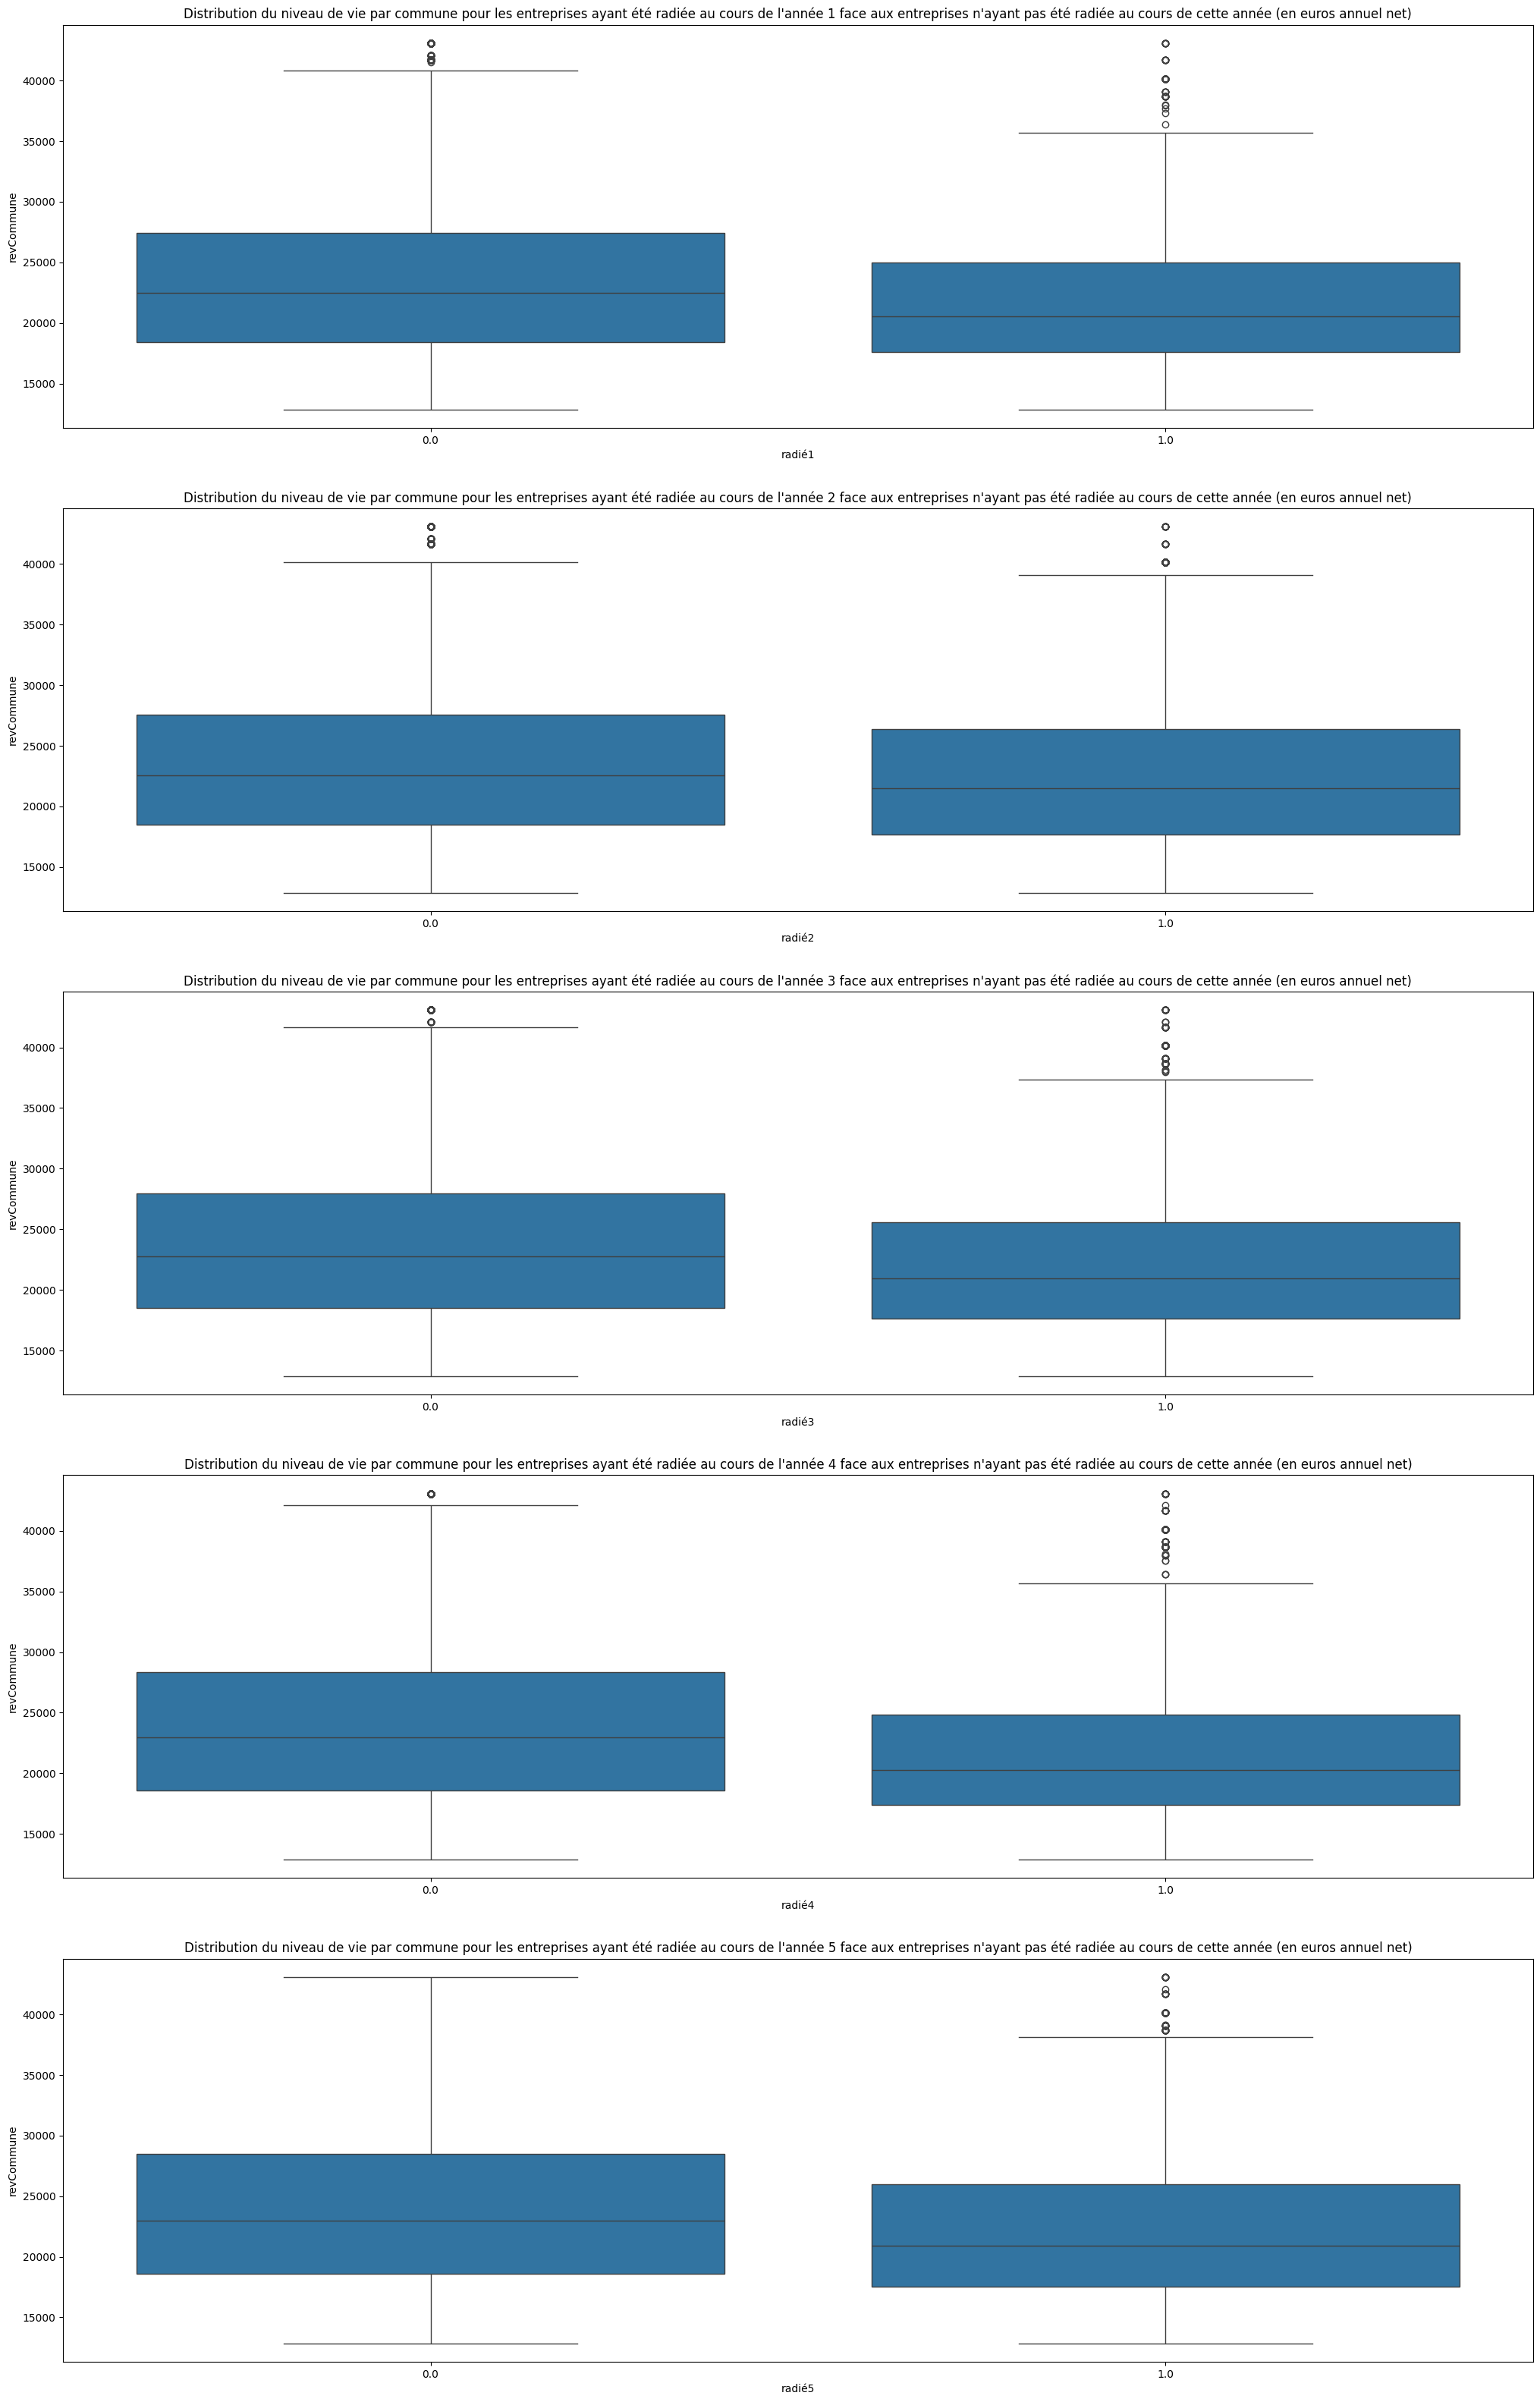

In [292]:
#Box plots donnant les distributions du niveau de vie par commune pour les entreprises ayant été radiée au cours de l'année i
var_cible = ["radié1","radié2","radié3","radié4","radié5"]

fig, ax = plt.subplots(5,1,figsize=(25,40))
for i in range(len(dfs)):
    var_name = var_cible[i]
    sns.boxplot(x = var_name, y = "revCommune", data = dfs[i], ax = ax[i])
    ax[i].set_title(f"Distribution du niveau de vie par commune pour les entreprises ayant été radiée au cours de l'année {i+1} face aux entreprises n'ayant pas été radiée au cours de cette année (en euros annuel net)")

Pour évaluer les choses de manière un peu plus rigoureuse, on regresse `revCommune` sur chaque variable `radié_i` et on évalue les coefficients obtenus. On considère donc $\hat{revCommune} = \hat{ \alpha } + \hat{\beta_i} * radié_{i}$, où $\hat{ \beta_i }$ correspond à la différence des moyennes de `revCommune` entre les entreprises radiés au cours de l'année i et celle non radiée au cours de cette année.

On test $H_0$ : $\beta_i = 0$ VS $H_1$ : $\beta_i\neq 0$.

On remarque alors que l'ensemble des $\beta_i$, $i \in \{1,2,3,4,5\}$, sont significatifs au seuil asymptotique de 5%, tous négatifs, et en volume conséquent. Autrement dit, le fait d'avoir été radiée au cours de l'année i est corrélé est corrélé avec une diminution du salaire local médian allant de 554 euros (i == 2) à 1460 euros (i == 4), significativement au seuil asymptotique de 5%, toutes choses égales par ailleurs. L'hétérogénéité entre les années sur lesquelles les radiations sont comptées est cependant difficile à interpréter. 

Globalement, on peut affirmer qu'une différence demeure bel et bien entre entreprise radié et non-radié au cours de l'année i, vis-à-vis de la variable `revCommune`. Elle sera donc à tester dans une future modélisation.

In [293]:
var_cible = ["radié1","radié2","radié3","radié4","radié5"]

for df,var_name in zip(dfs,var_cible):
    X = df[[var_name,"nb_local_concurrents"]] #Ajout de nb_local_concurrents pour contrôle
    X = sm.add_constant(X)
    y = df["revCommune"]

    #On regresse et on récupère les écarts types robustes
    model = sm.OLS(y, X).fit(cov_type="HC1")

    coef = model.params[var_name]   
    pval = model.pvalues[var_name]

    print(f"Année {var_name[-1]} suivant la création coefficient",coef)
    print(f"Année {var_name[-1]} suivant la création p-value",pval, "\n")
    

Année 1 suivant la création coefficient -1350.2476223929777
Année 1 suivant la création p-value 1.6828456760864321e-37 

Année 2 suivant la création coefficient -456.87268507431133
Année 2 suivant la création p-value 4.7048073382804086e-05 

Année 3 suivant la création coefficient -1251.129889420135
Année 3 suivant la création p-value 2.736242709902431e-51 

Année 4 suivant la création coefficient -1939.9929897517095
Année 4 suivant la création p-value 6.388334435797165e-111 

Année 5 suivant la création coefficient -1529.1665881372521
Année 5 suivant la création p-value 5.890689572296613e-51 



### L'expérience de l'entrepreneur/des associés est-elle un facteur améliorant du taux de radiation d'entreprises ?

In [294]:
data["sumxp"] = (data["total_exp0"] + data["total_exp1"] + data["total_exp2"]
+ data["total_exp3"] + data["total_exp4"] + data["total_exp5"])

Valeurs extrêmes pour sumxp

In [295]:
data["sumxp"].describe()

count    148372.000000
mean          0.952538
std           6.464980
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         309.000000
Name: sumxp, dtype: float64

Nous voulons nous centrer sur des entreprises de tailles raisonnable. En règle générale, les associés s'investissant dans une entreprise ayant un nombre très élevé d'entreprises à leur actif (> 10) peuvent être le signe que l'entreprise est-elle même de grosse envergure. 
Ainsi, afin de réduire au maximum les chances de rencontrer des entreprises de tailles élevé, nous nous restreignons aux entreprises pour lesquelles la somme des expériences totales pour chaque associé est inférieur à 10. Ce seuil est déterminé de manière factuelle et peut être discuter.

In [296]:
data = data.loc[data["sumxp"] <= 10]

In [297]:
dfs = get_df_i(data)

Visualisation du pourcentage de radiation durant l'année i suivant la creation par nombre total d'expérience (limité à 10 max)

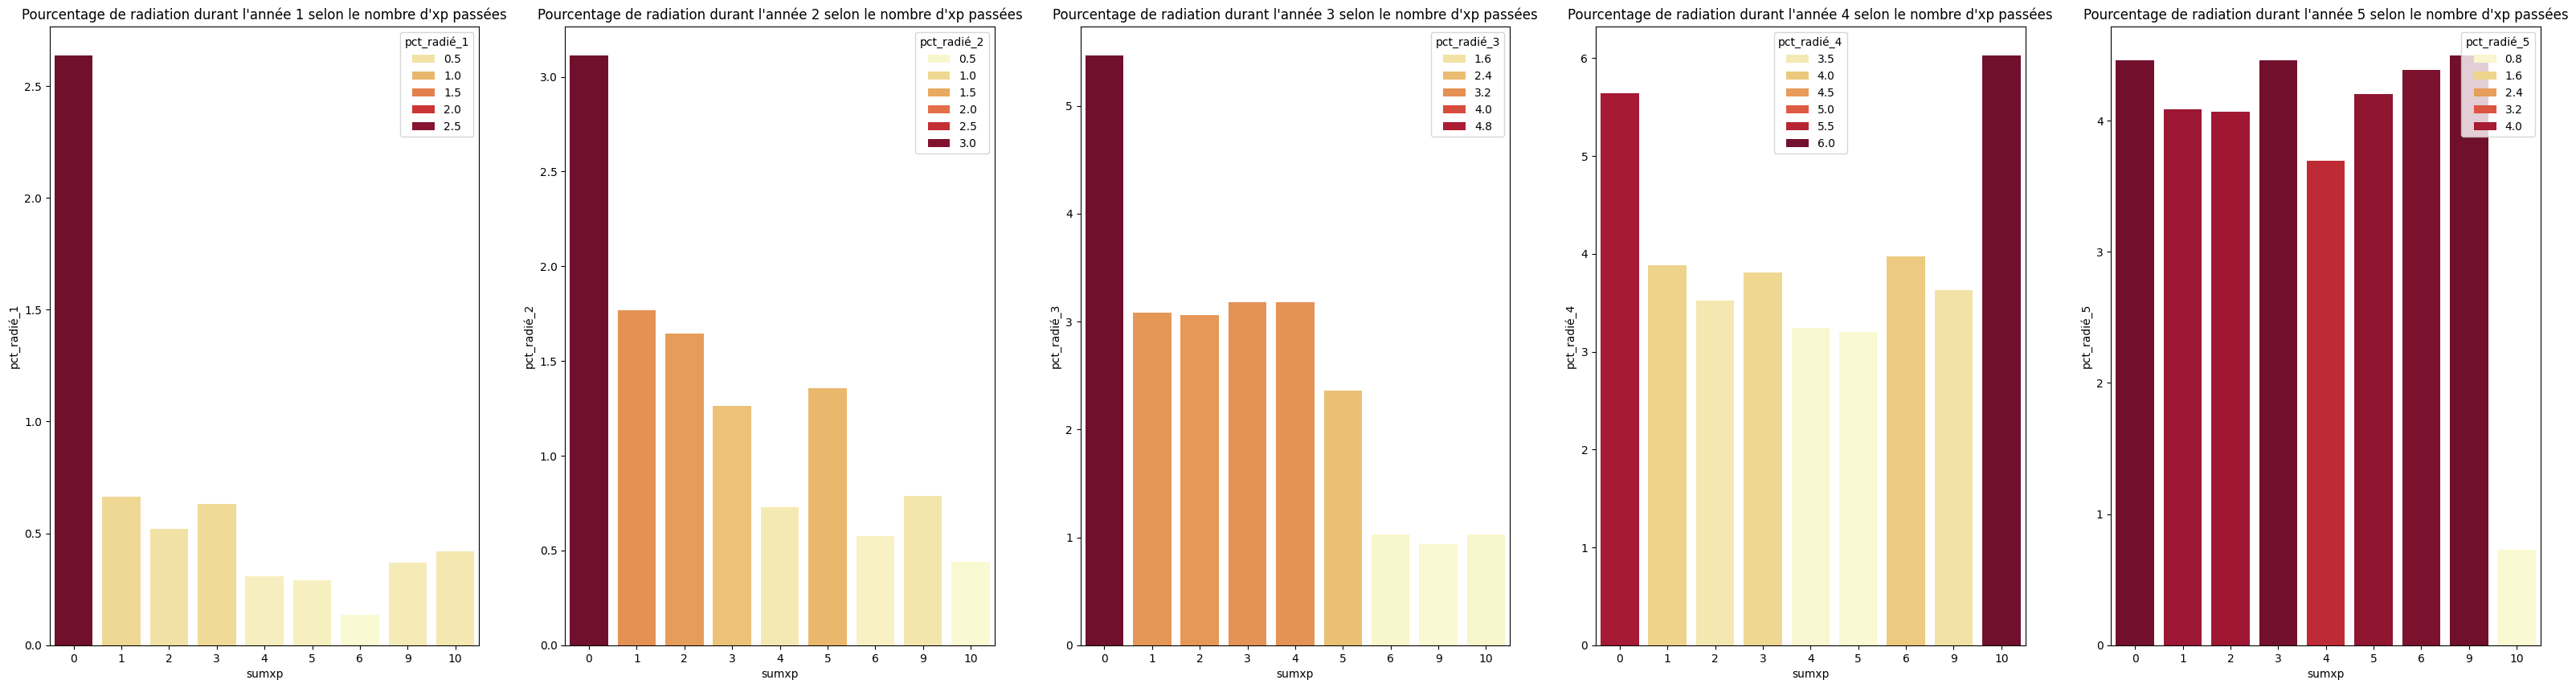

In [298]:
title = [f"Pourcentage de radiation durant l'année {i+1} selon le nombre d'xp passées" for i in range(5)]
figsize = (40,10)
barplot_cat("sumxp",dfs,figsize,title)

Visualisation du pourcentage de radiation durant l'année i suivant la creation par nombre total d'expérience ayant aboutit à une radiation d'entreprise (limité à 10 max)

In [299]:
data["sumxp_rad"] = (data["total_rad0"] + data["total_rad1"] + data["total_rad2"] 
+ data["total_rad3"] + data["total_rad4"] + data["total_rad5"])


In [300]:
dfs = get_df_i(data)

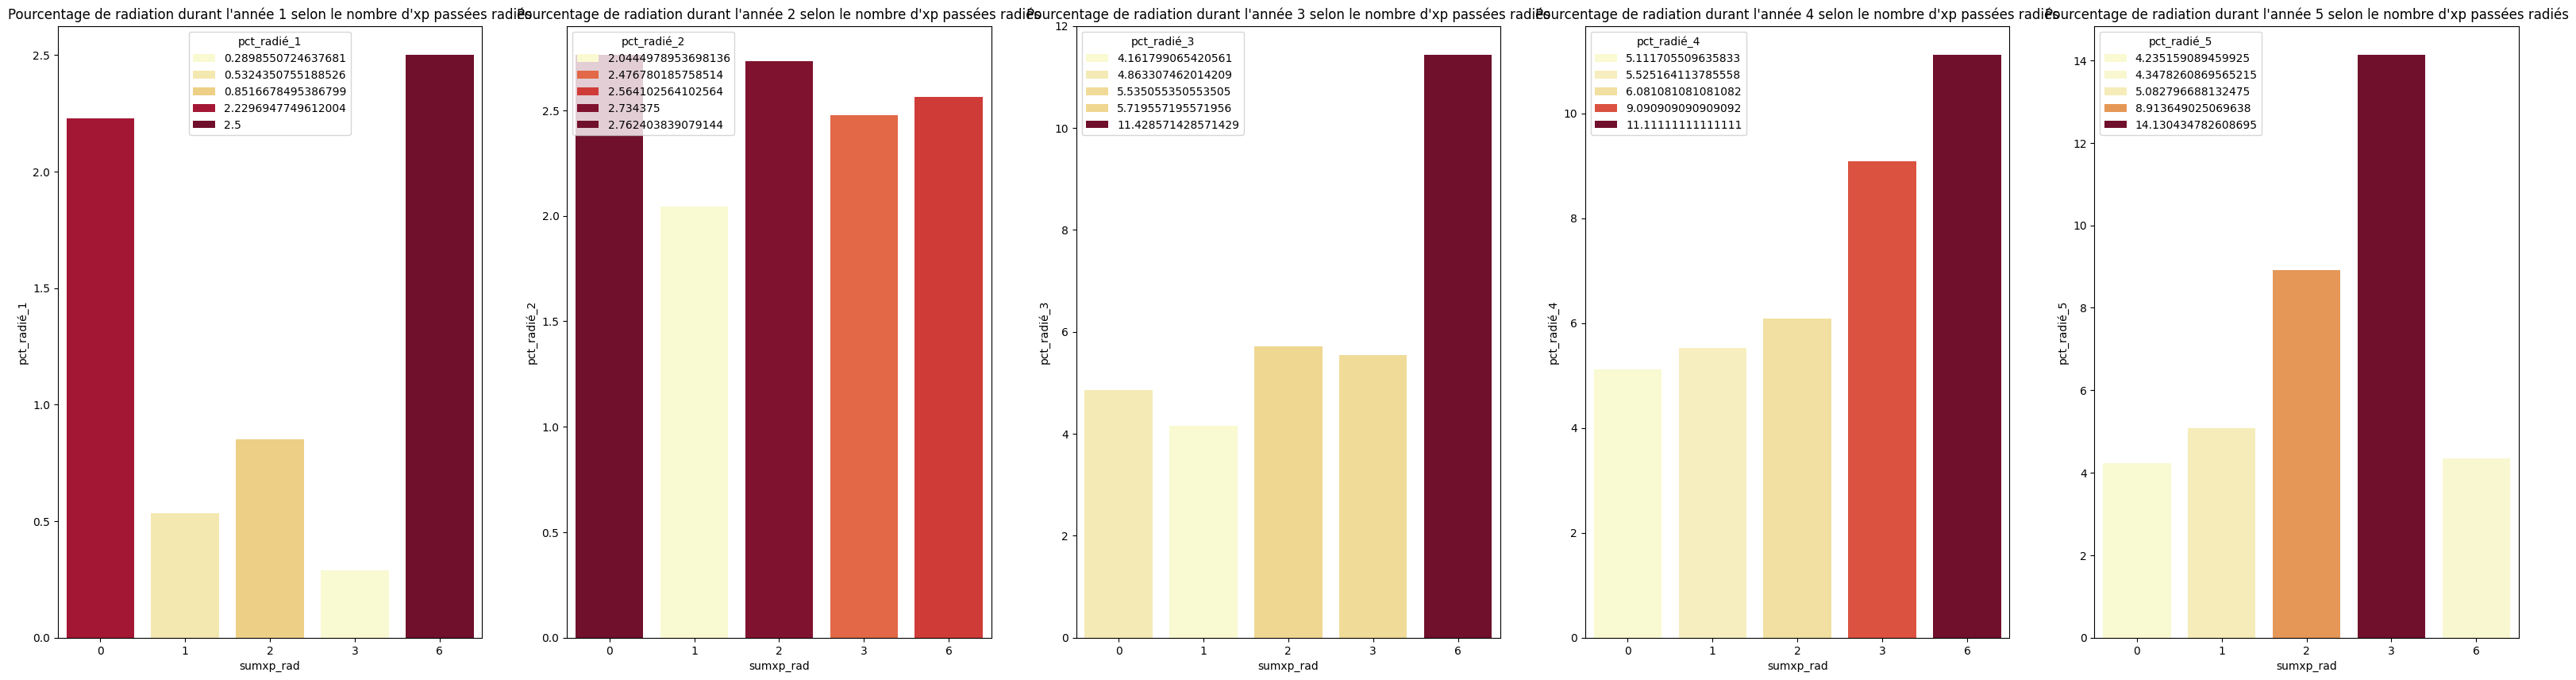

In [301]:
title = [f"Pourcentage de radiation durant l'année {i+1} selon le nombre d'xp passées radiés" for i in range(5)]
figsize = (40,10)
barplot_cat("sumxp_rad",dfs,figsize,title)

Pour les années 1 et 2 suivants la création, il est difficile de dire quelque chose. Pour les autres, il semble que plus les associés ont connus des radiations pour raisons quelconques, plus ils ont des chances d'être radiés.

Visualisation du pourcentage de radiation durant l'année i suivant la creation par nombre total d'expérience en lien avec le secteur d'activité de l'entreprise actuelle (limité à 10 max)

In [302]:
data["sumxp_ape"] = (data["ape_true0"] + data["ape_true1"] + data["ape_true2"] 
+ data["ape_true3"] + data["ape_true4"] + data["ape_true5"])

data["ape_true/sumxp"] = data["sumxp_ape"]/data["sumxp"]

In [303]:
dfs = get_df_i(data)

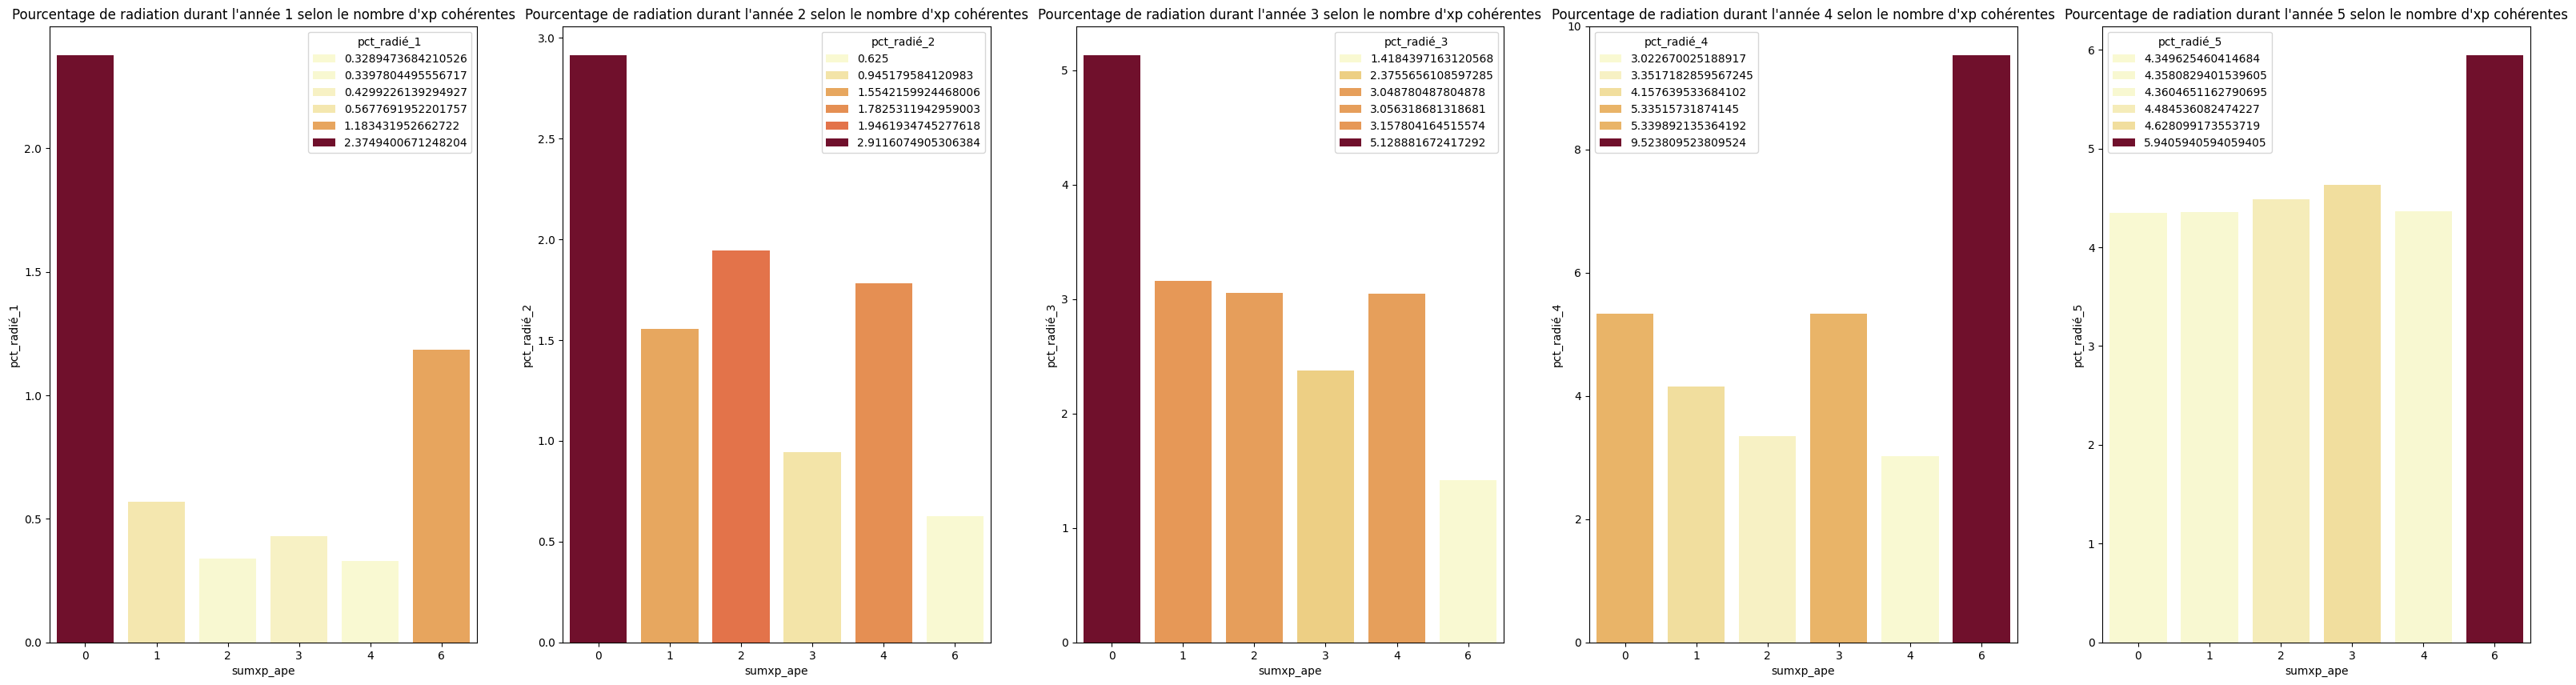

In [304]:
title = [f"Pourcentage de radiation durant l'année {i+1} selon le nombre d'xp cohérentes" for i in range(5)]
figsize = (40,10)
barplot_cat("sumxp_ape",dfs,figsize,title)

Il est difficile de trouver une cohérence ici.

Visualisation de la distribution des entreprises radiées vs non-radiés au cours de l'année i selon l'âge moyen des entreprises :

On remarque qu'il y a globalement une différence entre l'âge moyen des associés qui ont connus une radiation au cours de l'année i, et ceux qui n'en n'ont pas connus au cours de cette année, et cela pour tout $i \in \{1,2,3,4,5\}$. Cette différence est cependant légère. Il faut donc tester cela.

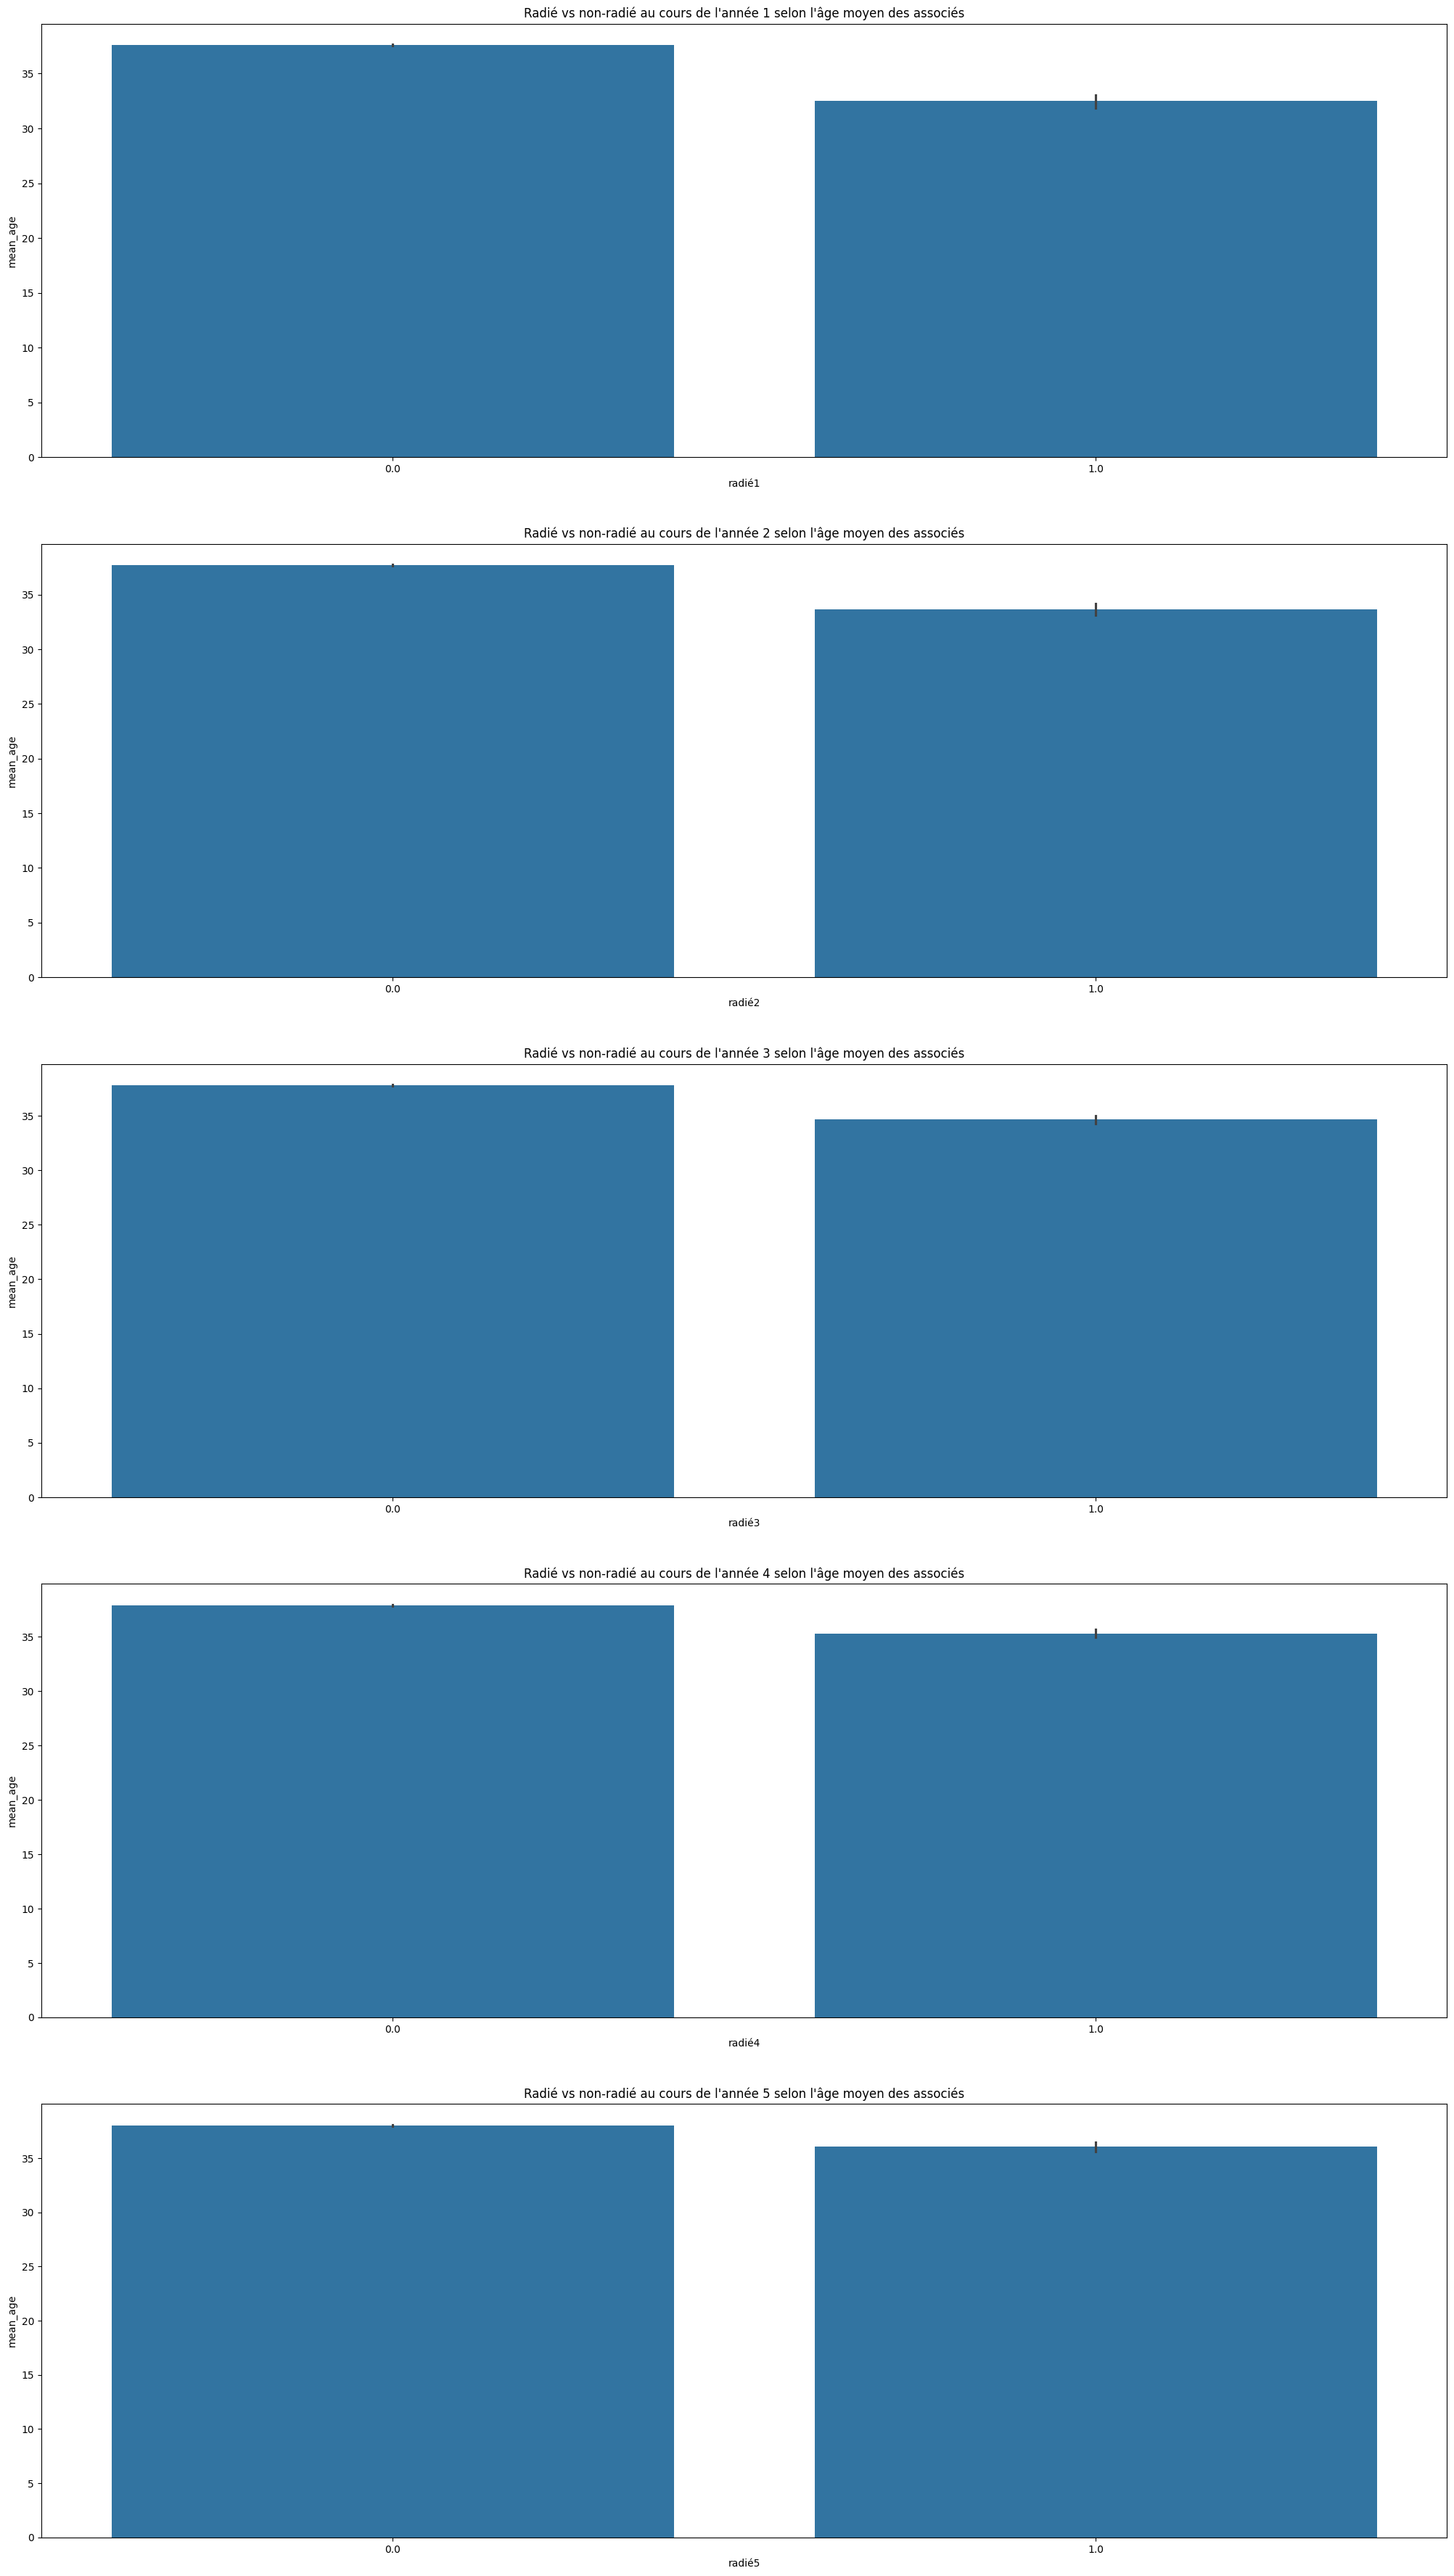

In [305]:
var_cible = ["radié1","radié2","radié3","radié4","radié5"]

fig, ax = plt.subplots(5,1,figsize=(25,45))
for i in range(len(var_cible)):
    var_name = var_cible[i]
    sns.barplot(x = var_name, y = "mean_age",data=dfs[i],ax = ax[i])
    ax[i].set_title(f"Radié vs non-radié au cours de l'année {i+1} selon l'âge moyen des associés")


Comme précémment, pour tester cette différence, on regresse `mean_age` sur `radié_i`. 

Il s'avère alors que l'ensemble des coefficients pour `radié_i` sont significatifs au seuil asymptotique de 5%. Il faudra donc garder ces variables et les tester dans une future modélisation.

In [306]:
var_cible = ["radié1","radié2","radié3","radié4","radié5"]

for df,var_name in zip(dfs,var_cible):
    X = df[[var_name,"nb_associe","sumxp"]] #Ajout de nb_associe, sumxp pour contrôle
    X = sm.add_constant(X)
    y = df["mean_age"]

    #On regresse et on récupère les écarts types robustes
    model = sm.OLS(y, X).fit(cov_type="HC1")

    coef = model.params[var_name]   
    pval = model.pvalues[var_name]


    print(f"Année {var_name[-1]} suivant la création coefficient",coef)
    print(f"Année {var_name[-1]} suivant la création p-value",pval, "\n")

Année 1 suivant la création coefficient -4.594830997321851
Année 1 suivant la création p-value 8.3160228279134e-52 

Année 2 suivant la création coefficient -3.684326036395995
Année 2 suivant la création p-value 1.080190575821721e-45 

Année 3 suivant la création coefficient -2.83116020456191
Année 3 suivant la création p-value 1.2883222547306576e-54 

Année 4 suivant la création coefficient -2.407926662956105
Année 4 suivant la création p-value 2.9282500952557333e-39 

Année 5 suivant la création coefficient -1.8543923940378582
Année 5 suivant la création p-value 3.1339843885199983e-18 



## Conclusion de cette analyse de données

Au final, après analyse, on décide de garder les variables suivantes pour les tester dans une modélisation future : 

Variables de localisation et d'environnement : 

`cp`

`taille_ville`

`concu\hab`

`revCommune`

`revDep`

`nb_local_concurrents`

`pop_commune`

Variables de secteurs d'activités et de type d'entreprises :

`codeAPE`

Variables d'expérience et nombre d'associés :

`mean_age`

`sumxp`

`sumxp_rad`

`nb_associe`

Variables sur le type d'entreprise : 

`personneMorale`

`micro`


Variables cibles :

`radié1`

`radié2`

`radié3`

`radié4`

`radié5`


Autres variables n'ayant pas été déterminées par l'analyse mais qui pourront servir à la création de pipeline pour de la prédiction : 

`objet`

`codeInseeCommune`

`montantCapital`

`date_creation`

`siren`



On peut alors à présent récupérer le data frame qui servira de base pour la modélisation. Ce data frame est sauvegardé sur le coud ssp cloud s3.

In [85]:

variables = [
    # Variables de localisation et d'environnement
    "cp",
    "taille_ville",
    "concu/hab",
    "revCommune",
    "revDep",
    "nb_local_concurrents",
    "pop_commune",
    
    # Variables de secteurs d'activités et type d'entreprise
    "codeAPE",
    
    # Variables d'expérience et nombre d'associés
    "mean_age",
    "sumxp",
    "sumxp_rad",
    "nb_associe",
    
    # Variables sur le type d'entreprise
    "formeJuridique",
    "personneMorale",
    "micro",
    
    # Variable de genre
    "genre",
    
    # Variables cibles
    "radié1",
    "radié2",
    "radié3",
    "radié4",
    "radié5",
    
    # Autres variables utiles pour le pipeline
    "objet",
    "codeInseeCommune",
    "code_postal",
    "montantCapital",
    "date_creation",
    "siren"
]

#création du DataFrame pour la modélisation
data_model = data[variables].copy()

print(data_model.shape)



(146523, 27)


In [86]:
"""
#Connexion à S3
os.environ["AWS_ACCESS_KEY_ID"] = getpass.getpass()
os.environ["AWS_SECRET_ACCESS_KEY"] = getpass.getpass()
os.environ["AWS_SESSION_TOKEN"] = getpass.getpass()
os.environ["AWS_DEFAULT_REGION"] = 'us-east-1'
fs = s3fs.S3FileSystem(
    client_kwargs={'endpoint_url': 'https://'+'minio.lab.sspcloud.fr'},
    key = os.environ["AWS_ACCESS_KEY_ID"], 
    secret = os.environ["AWS_SECRET_ACCESS_KEY"], 
    token = os.environ["AWS_SESSION_TOKEN"])
"""

'\n#Connexion à S3\nos.environ["AWS_ACCESS_KEY_ID"] = getpass.getpass()\nos.environ["AWS_SECRET_ACCESS_KEY"] = getpass.getpass()\nos.environ["AWS_SESSION_TOKEN"] = getpass.getpass()\nos.environ["AWS_DEFAULT_REGION"] = \'us-east-1\'\nfs = s3fs.S3FileSystem(\n    client_kwargs={\'endpoint_url\': \'https://\'+\'minio.lab.sspcloud.fr\'},\n    key = os.environ["AWS_ACCESS_KEY_ID"], \n    secret = os.environ["AWS_SECRET_ACCESS_KEY"], \n    token = os.environ["AWS_SESSION_TOKEN"])\n'

In [87]:
import os
import s3fs
os.environ["AWS_ACCESS_KEY_ID"] = 'RRV1Y403JCISF2NWZ7WI'
os.environ["AWS_SECRET_ACCESS_KEY"] = 'dK3U1Xz3GIqZncRL4OU+WW4MoGpoIM6Ppbcwu99w'
os.environ["AWS_SESSION_TOKEN"] = 'eyJhbGciOiJIUzUxMiIsInR5cCI6IkpXVCJ9.eyJhY2Nlc3NLZXkiOiJSUlYxWTQwM0pDSVNGMk5XWjdXSSIsImFsbG93ZWQtb3JpZ2lucyI6WyIqIl0sImF1ZCI6WyJtaW5pby1kYXRhbm9kZSIsIm9ueXhpYSIsImFjY291bnQiXSwiYXV0aF90aW1lIjoxNzY2NDIzNjMyLCJhenAiOiJvbnl4aWEiLCJlbWFpbCI6Imd1aWxsYXVtZS5yb3VzdGFuQGVuc2FlLmZyIiwiZW1haWxfdmVyaWZpZWQiOnRydWUsImV4cCI6MTc2NzA0NDc3OCwiZmFtaWx5X25hbWUiOiJSb3VzdGFuIiwiZ2l2ZW5fbmFtZSI6Ikd1aWxsYXVtZSIsImdyb3VwcyI6WyJVU0VSX09OWVhJQSJdLCJpYXQiOjE3NjY0Mzk5NzgsImlzcyI6Imh0dHBzOi8vYXV0aC5sYWIuc3NwY2xvdWQuZnIvYXV0aC9yZWFsbXMvc3NwY2xvdWQiLCJqdGkiOiJvbnJ0cnQ6MzhlYjA1MDktMzAyZC1iZGI3LTU4Y2ItYTMyYWQ5N2VhY2RiIiwibG9jYWxlIjoiZnIiLCJuYW1lIjoiR3VpbGxhdW1lIFJvdXN0YW4iLCJwb2xpY3kiOiJzdHNvbmx5IiwicHJlZmVycmVkX3VzZXJuYW1lIjoiZ3VpbGxhdW1lMTc2IiwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbIm9mZmxpbmVfYWNjZXNzIiwidW1hX2F1dGhvcml6YXRpb24iLCJkZWZhdWx0LXJvbGVzLXNzcGNsb3VkIl19LCJyZXNvdXJjZV9hY2Nlc3MiOnsiYWNjb3VudCI6eyJyb2xlcyI6WyJtYW5hZ2UtYWNjb3VudCIsIm1hbmFnZS1hY2NvdW50LWxpbmtzIiwidmlldy1wcm9maWxlIl19fSwicm9sZXMiOlsib2ZmbGluZV9hY2Nlc3MiLCJ1bWFfYXV0aG9yaXphdGlvbiIsImRlZmF1bHQtcm9sZXMtc3NwY2xvdWQiXSwic2NvcGUiOiJvcGVuaWQgcHJvZmlsZSBncm91cHMgZW1haWwiLCJzaWQiOiJlNWJlYjY0MS1mMjAxLTI3YzMtYmIzZC02ZTU3M2RkNjFkMDMiLCJzdWIiOiI5Mjc4NzJjYi03NjgyLTRkNDAtYjliNy04M2IyYjk3YWRmMjgiLCJ0eXAiOiJCZWFyZXIifQ.akCi_v1hD5MmjiQCrdkhn-nBZl6QdG0gNaVth2bh4q-HY2RLQ7v-8JNTDFX1QGKdAWjJF0wK5qf-GZKPR-1IHQ'
os.environ["AWS_DEFAULT_REGION"] = 'us-east-1'
fs = s3fs.S3FileSystem(
    client_kwargs={'endpoint_url': 'https://'+'minio.lab.sspcloud.fr'},
    key = os.environ["AWS_ACCESS_KEY_ID"], 
    secret = os.environ["AWS_SECRET_ACCESS_KEY"], 
    token = os.environ["AWS_SESSION_TOKEN"])

In [88]:
#Stockage sur S3
MY_BUCKET = "guillaume176"

FILE_PATH_OUT_S3 = f"{MY_BUCKET}/diffusion/data_model/idf_10_24MODEL.parquet"

with fs.open(FILE_PATH_OUT_S3,"wb") as file_out:
    data_model.to_parquet(file_out, index=False)

print(f"Donnés chargés dans {FILE_PATH_OUT_S3}")

Donnés chargés dans guillaume176/diffusion/data_model/idf_10_24MODEL.parquet


Lien pour téléchargement idf_10_24MODEL.parquet : 

In [89]:
path_data = "guillaume176/diffusion/data_model"
file_list = fs.ls(path_data)[1:]
file_list = ["https://minio.lab.sspcloud.fr/" + f for f in file_list]
print(file_list[0])

https://minio.lab.sspcloud.fr/guillaume176/diffusion/data_model/idf_10_24MODEL.parquet
